In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from os import path
import math
import time
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import optimize
from utils import *

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
py4DSTEM.__version__

'0.12.6'

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [8.0, 6.0]

## Data Loading

In [8]:
#import and read data
file_folder = "./data/"
file_name = "example_3.dm4"
filepath_input = file_folder+file_name
datacube = py4DSTEM.io.read(filepath_input)

## Particle Identification

In [9]:
#look at data without margin area
datacube_origin = datacube.data[8:-8, 8:-8,:,:]

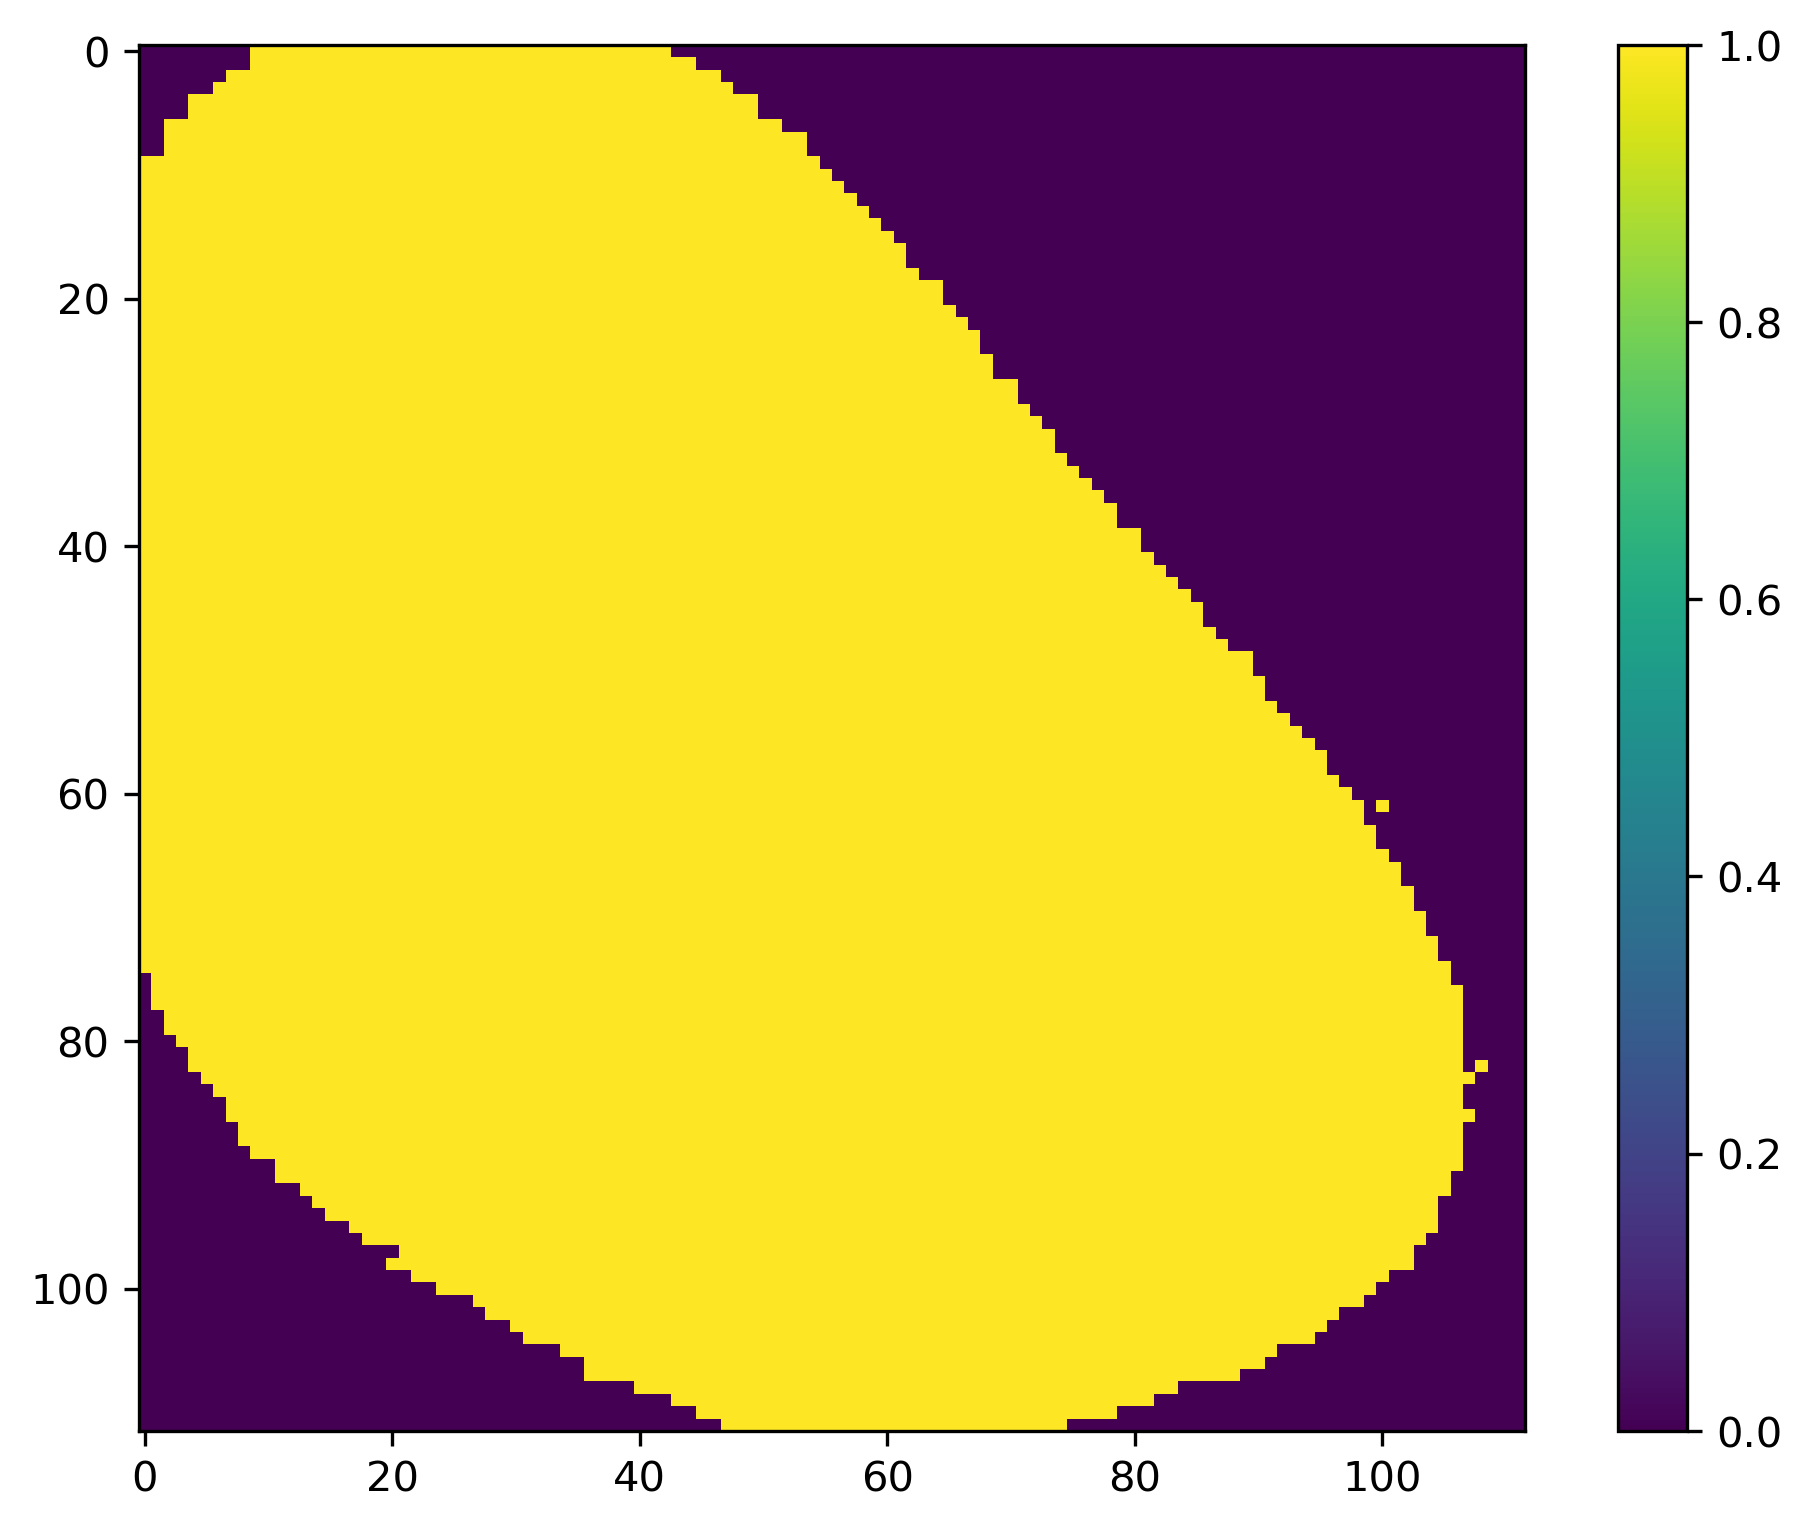

In [10]:
#threshold pixel values to indicate if a pixel belongs to particle area or not
particle_labels = IsParticle(datacube_origin, thres=58000)
plt.imshow(particle_labels);plt.colorbar()

## Average, symmetrization

In [11]:
#datacube_average: after spatially smoothing
#datacube_info: stores average info separately for display
#py4DSTEM function modifies the data in place
#so always keep storage separately if there is display needs in the future
datacube_average, datacube_info = average_datacube(datacube, n=8)

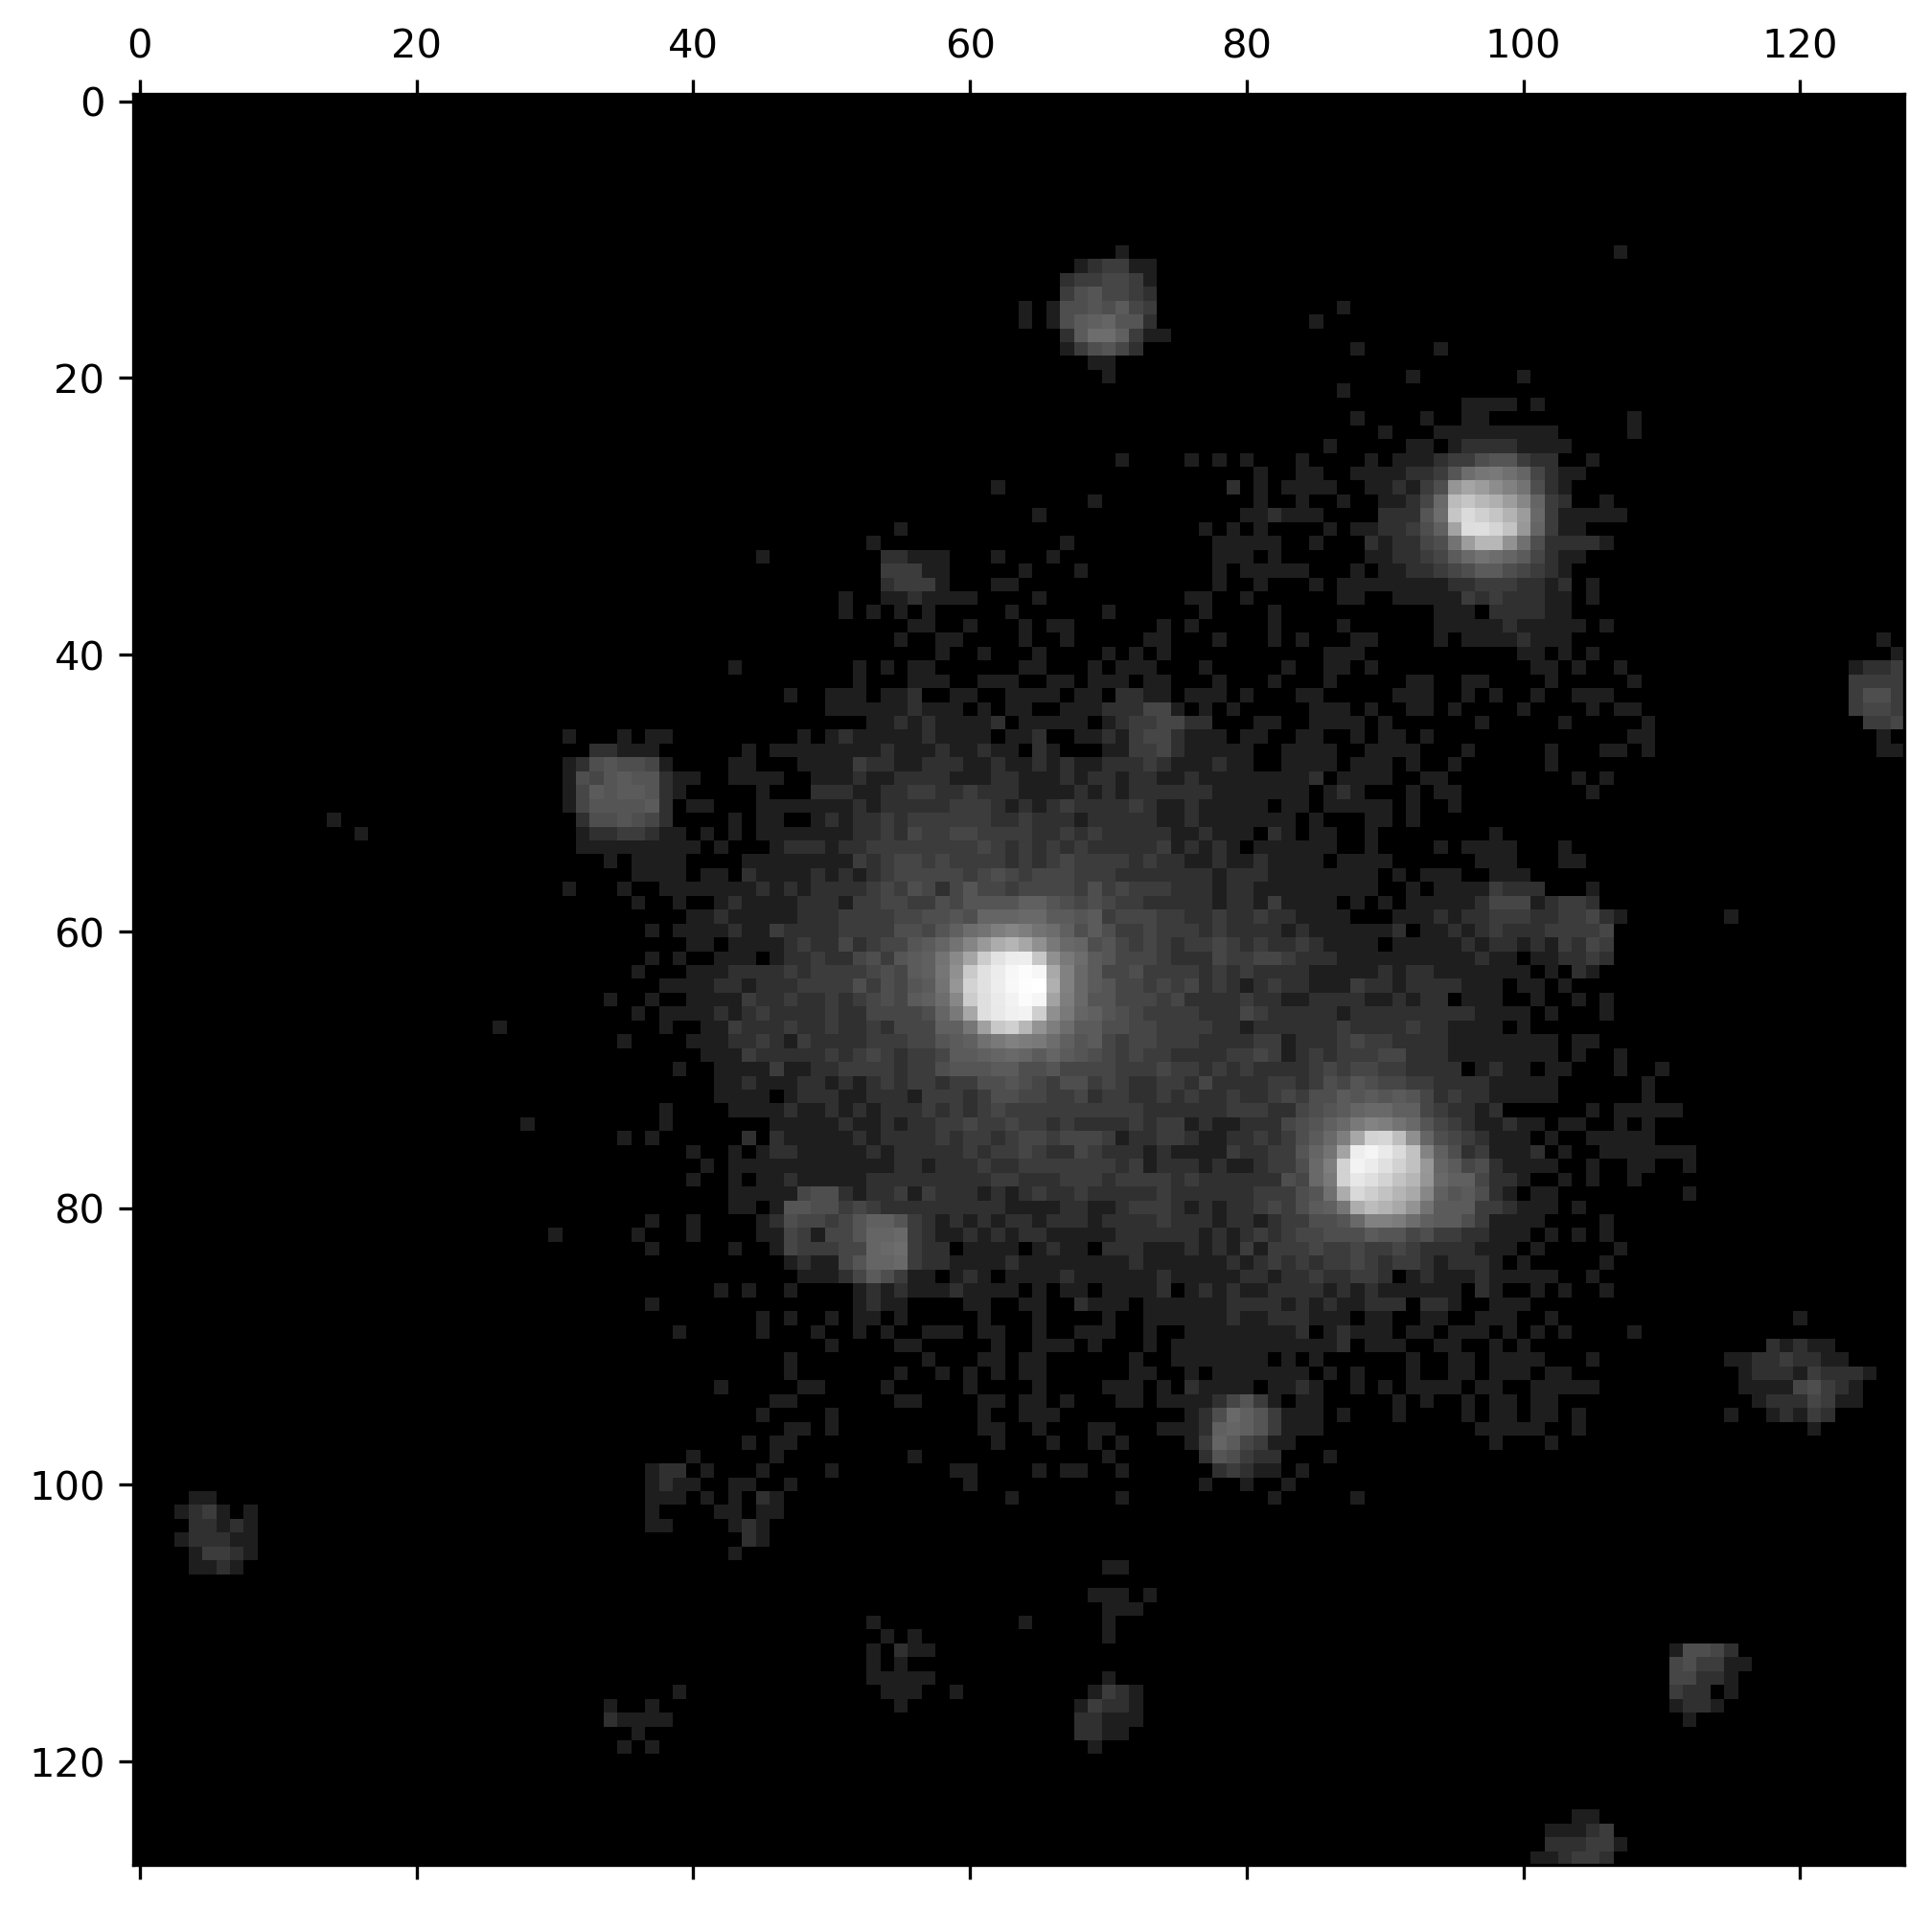

In [12]:
#display the DP at real space with coordinates [100, 40] after log-transformation
py4DSTEM.visualize.show(datacube_info[100][40], scaling='log')

In [13]:
#obtain the probe (kernel)
#use py4dstem functions
#obtain the center coordinates and assign to origin_x, origin_y
probe = py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan(datacube, mask_threshold=0.002, verbose = False)
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_gaussian(probe, sigma_probe_scale=2)
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel))
n = np.argmax(probe.flatten())
origin_x, origin_y = np.unravel_index(n, datacube_average.data.shape[2:])

100%|████████████████████████████████████| 12543/12543 [00:36<00:00, 341.86it/s]


In [14]:
#symmetrize the data
datacube_symmetrize, datacube_info_s = symmetrize_datacube(datacube_average, probe_kernel_FT, origin_x=origin_x, origin_y=origin_y)

100%|█████████████████████████████████████| 12544/12544 [05:25<00:00, 38.48it/s]


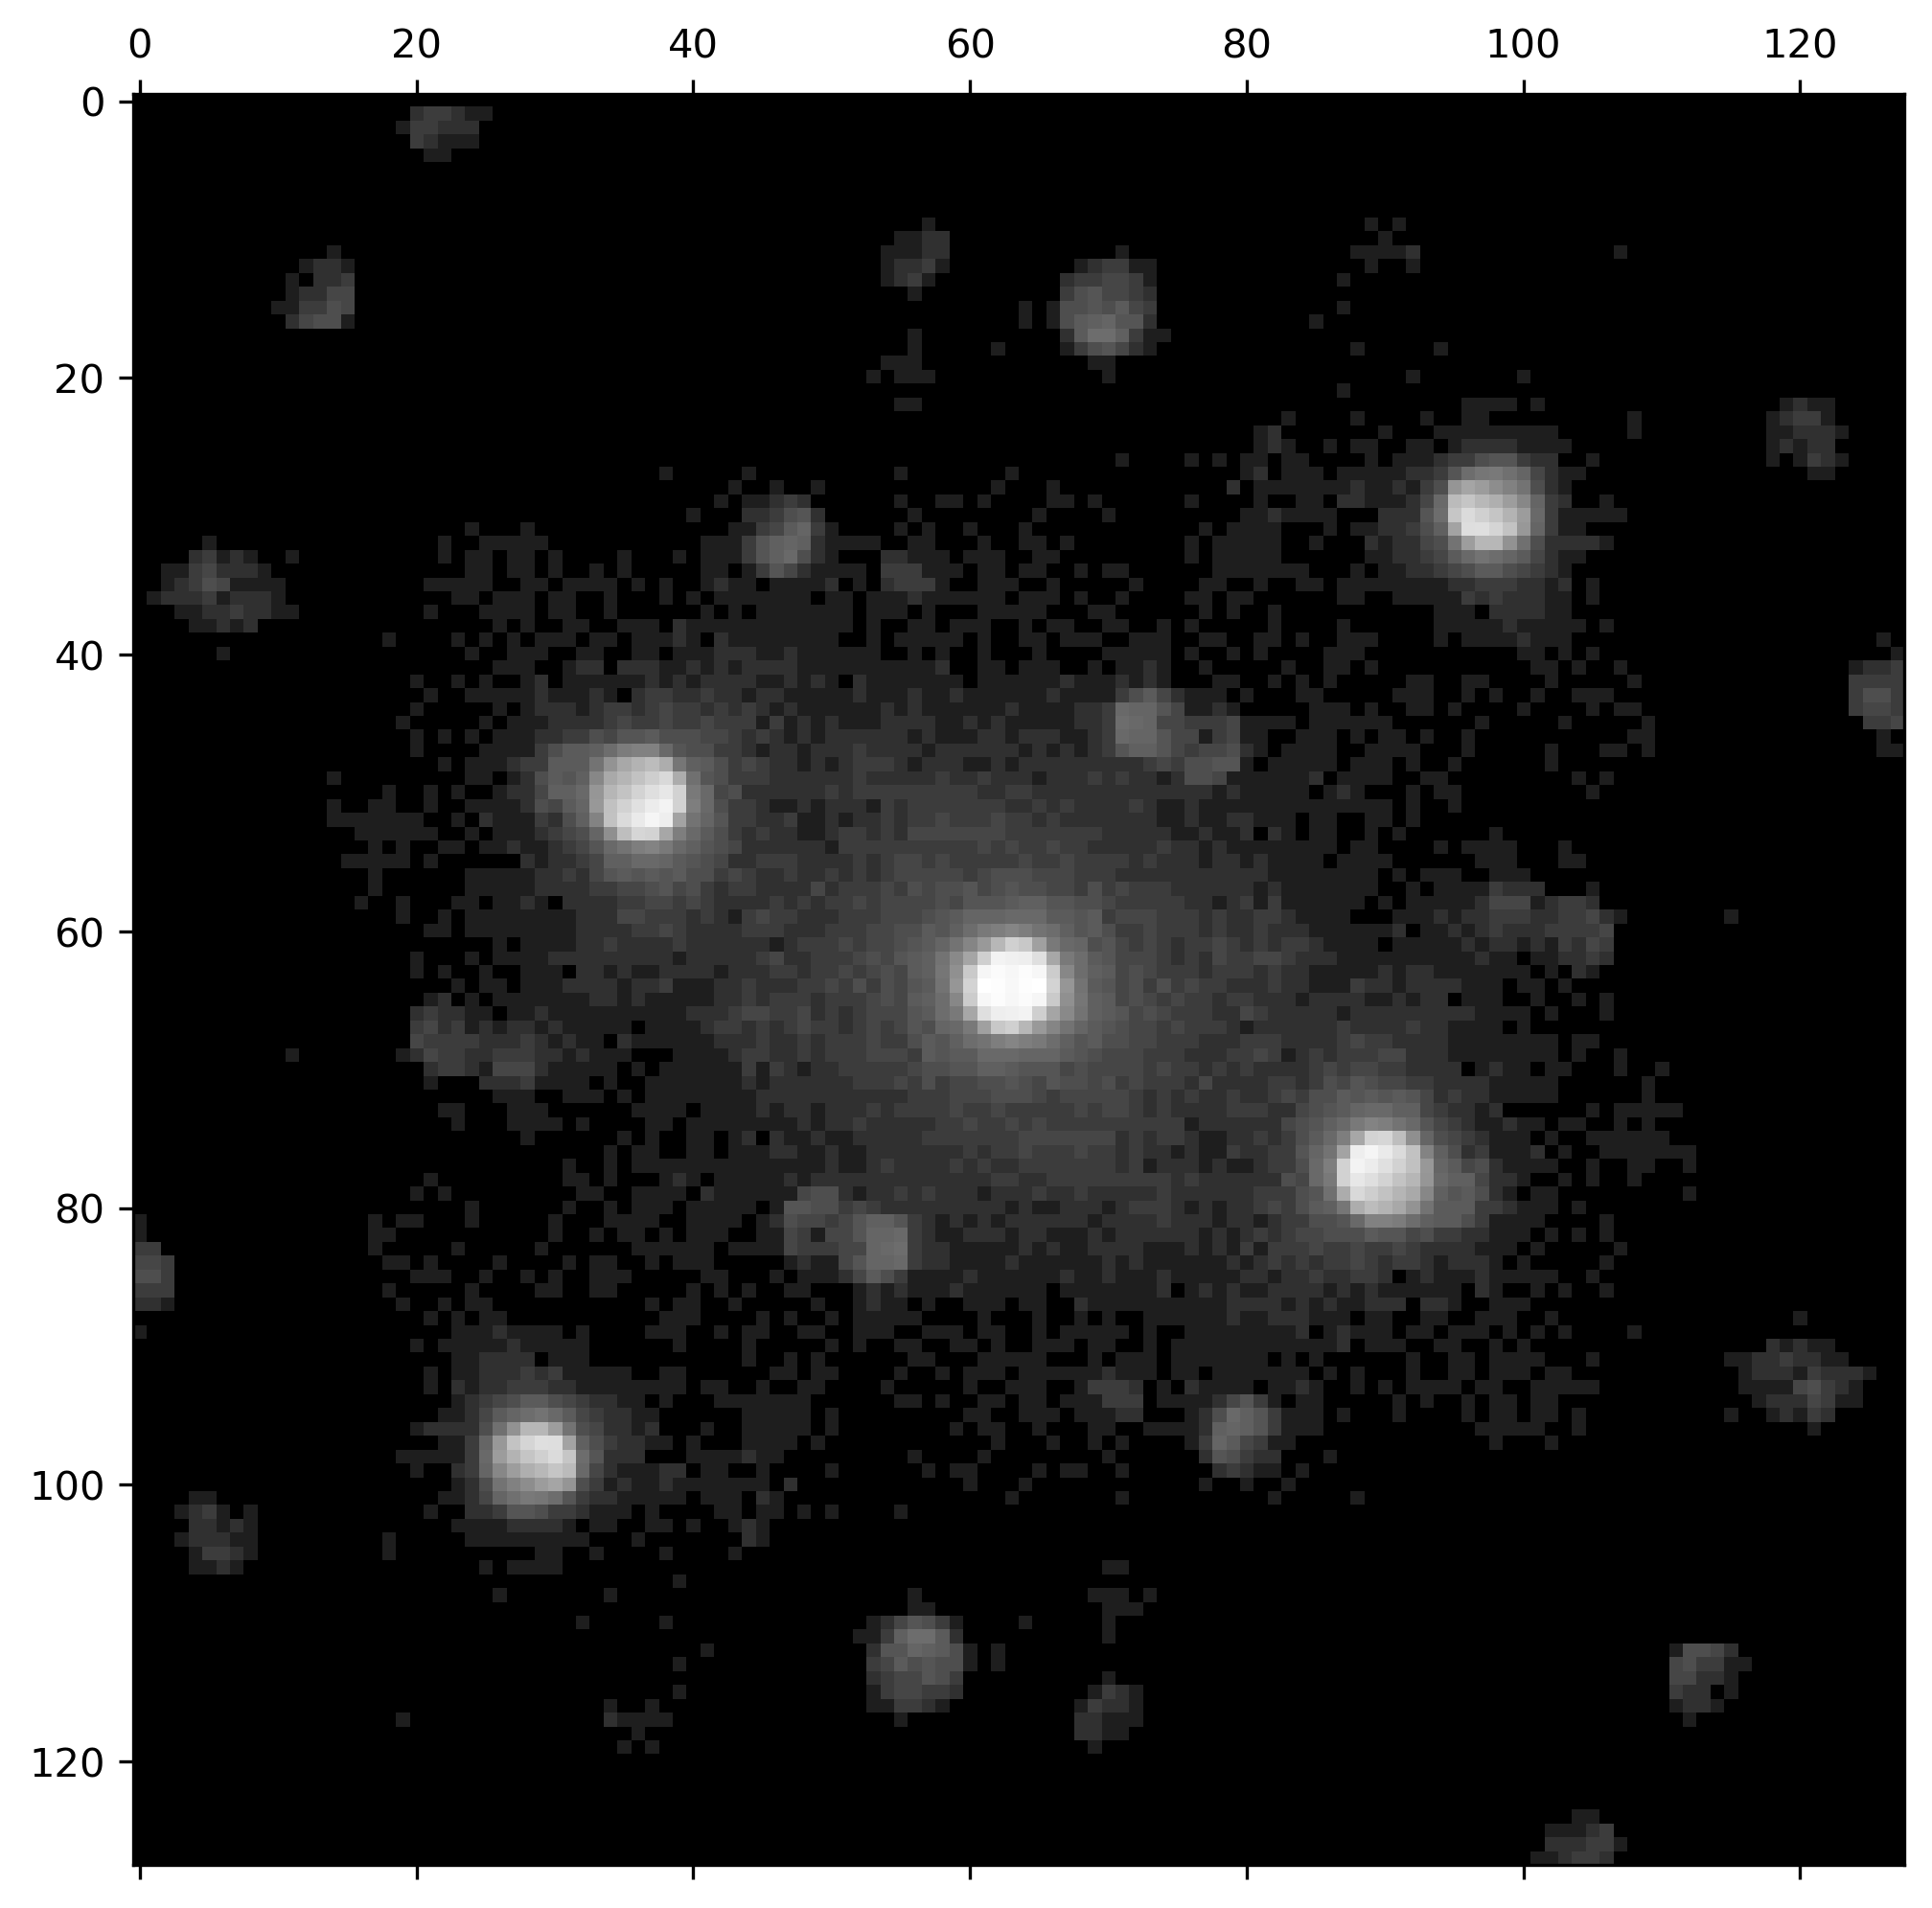

In [15]:
Rx, Ry = 100,40
py4DSTEM.visualize.show(datacube_symmetrize.data[Rx][Ry],scaling='log')

## Background Subtraction

In [16]:
particle_index, nonparticle_index, particle_count = generate_particle_index(datacube_symmetrize, particle_labels)

100%|█████████████████████████████████| 12544/12544 [00:00<00:00, 142083.81it/s]


In [17]:
#obtain the amplitude parameters from pixels in the background region
alpha_bg = bg_param(datacube_symmetrize, nonparticle_index, origin_x, origin_y)

100%|██████████████████████████████████████| 3637/3637 [00:35<00:00, 101.07it/s]


In [18]:
#obtain the estimated parameters of the function fitted to the integrated annular curve
#for all pixels that belong to the particle area
par_param = particle_param(datacube_symmetrize, particle_index, alpha_bg, origin_x, origin_y)

100%|███████████████████████████████████████| 8907/8907 [01:44<00:00, 85.39it/s]


In [19]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 300

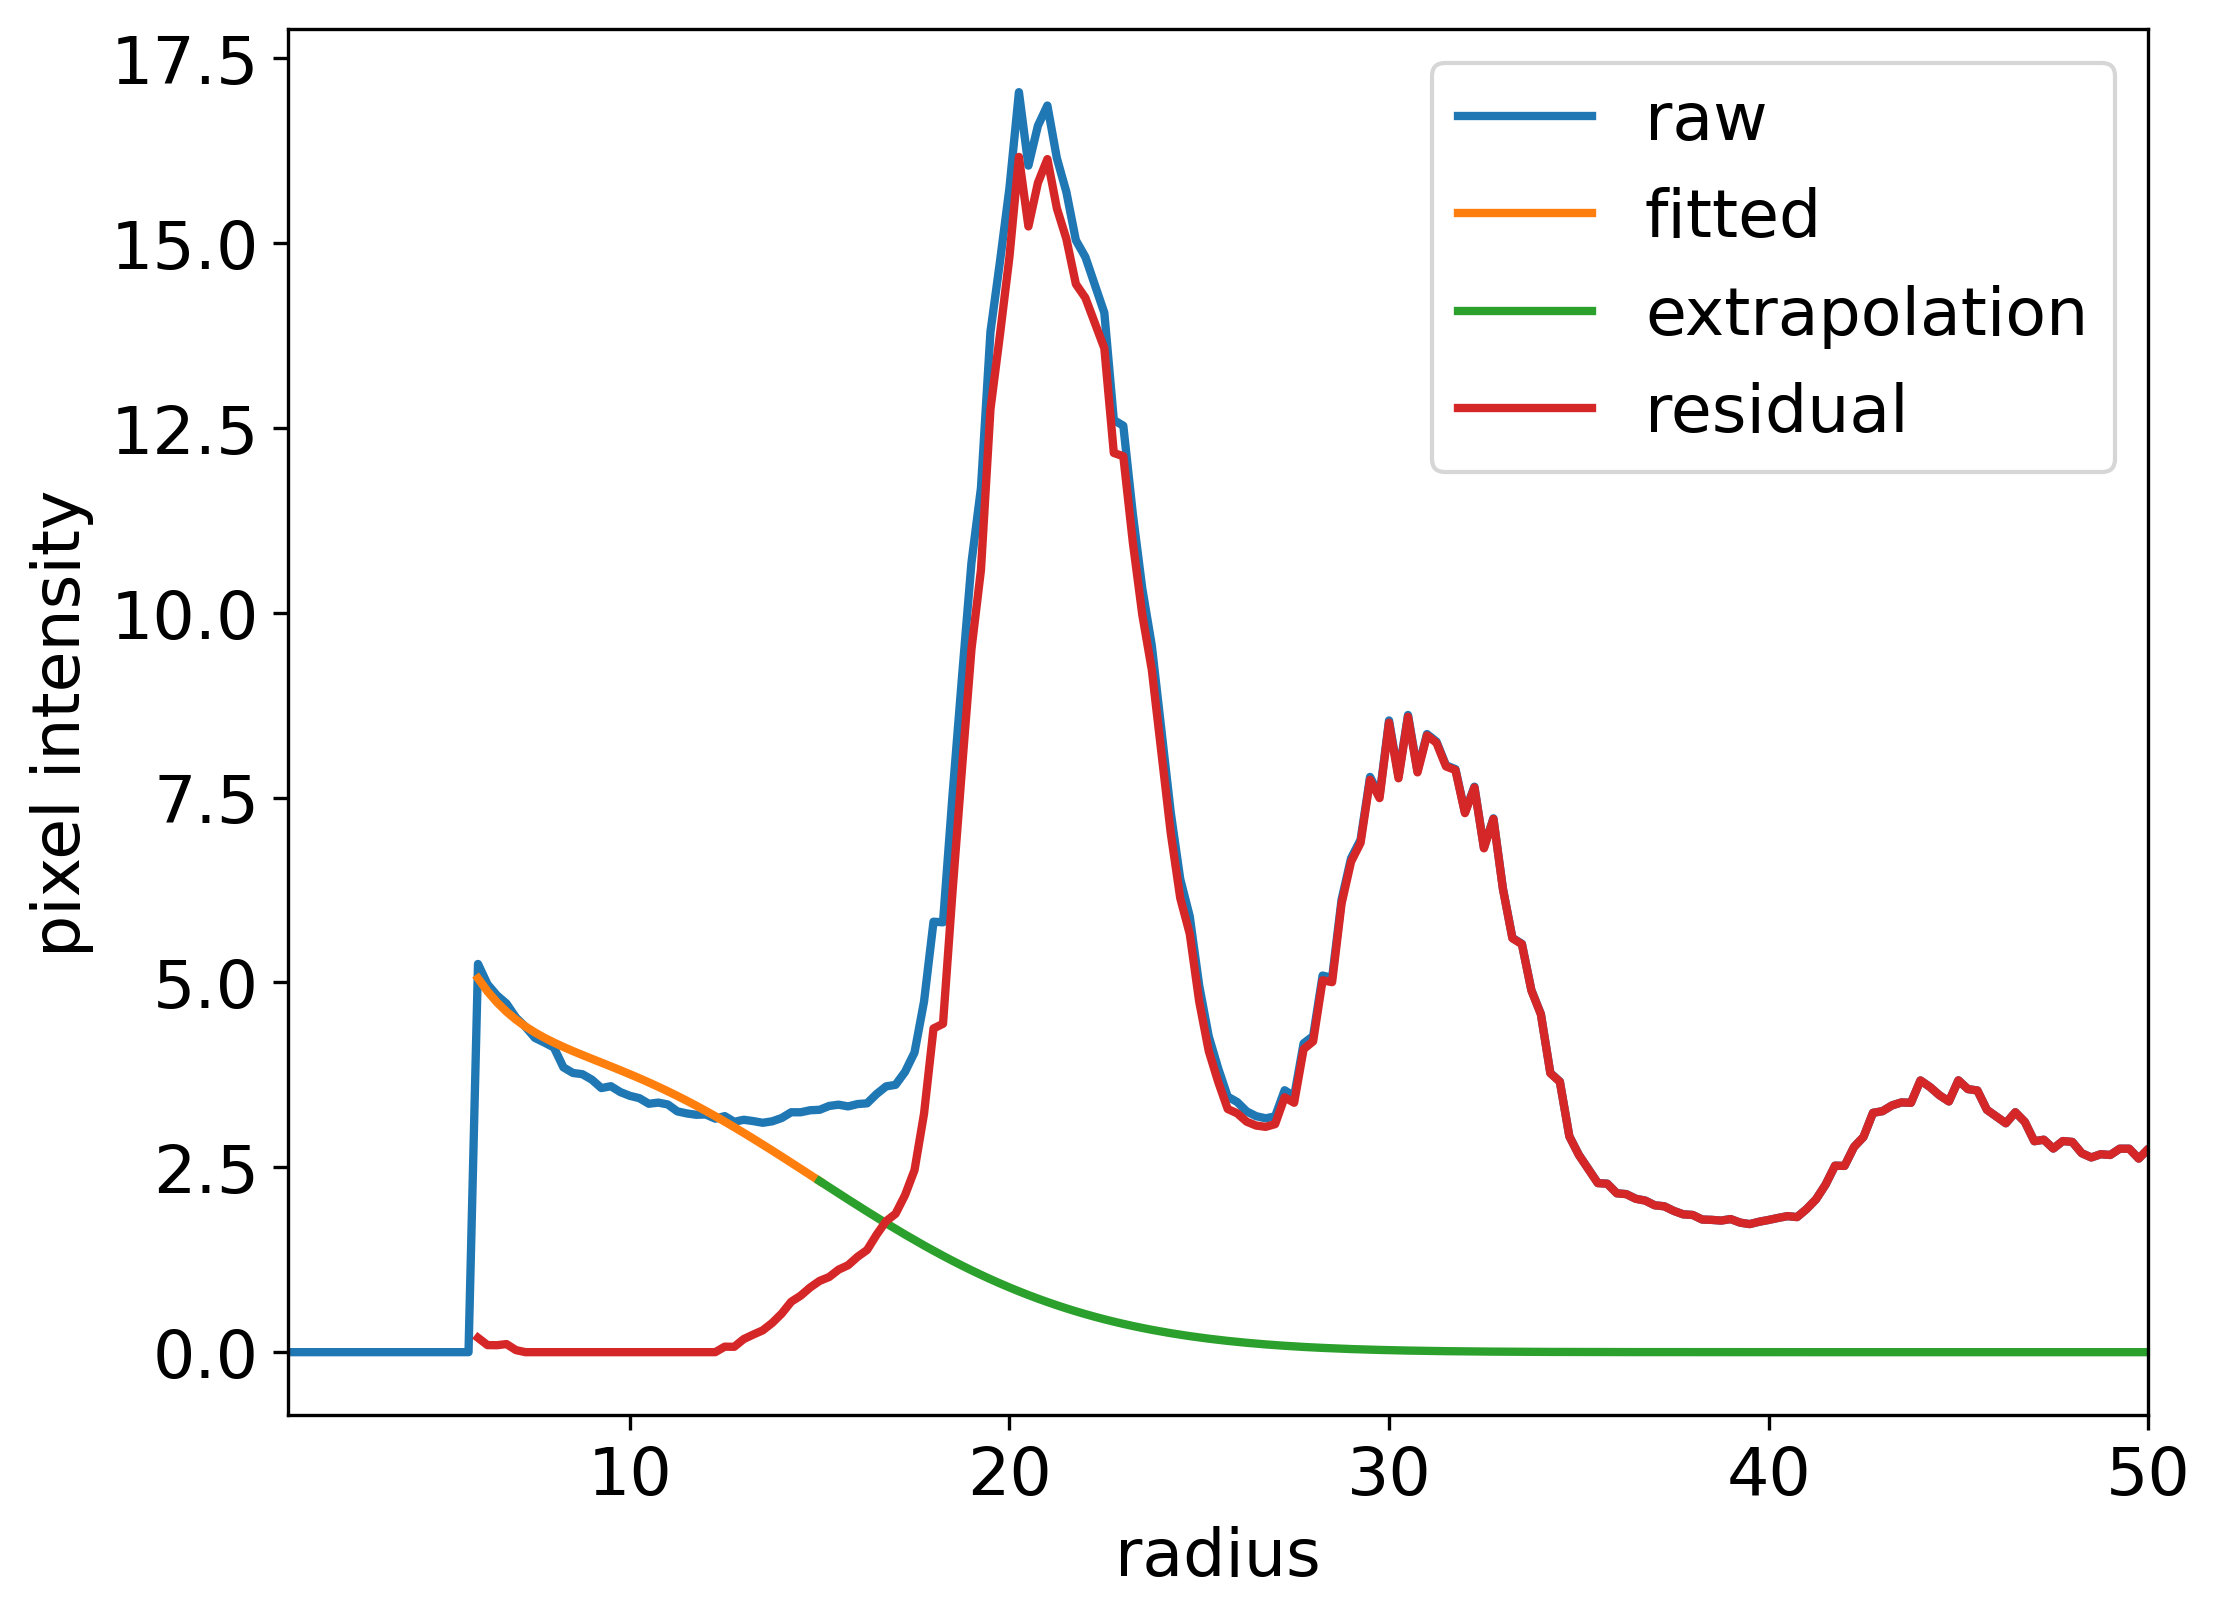

In [20]:
#look at fitted curve for pixle [60,85]
particle_curve(datacube_symmetrize, datacube_info_s, Rx=60, Ry=85, particle_index=particle_index, par_para=par_param, alpha_bg=alpha_bg, origin_x=origin_x, origin_y=origin_y)

In [21]:
#subtract the background from symmetrized DPs
center = [origin_x, origin_y]
datacube_symmetrize = subtract_bg(datacube_symmetrize, particle_index, par_param, center, alpha_bg)

100%|███████████████████████████████████████| 8907/8907 [11:44<00:00, 12.64it/s]


# Bragg disk detection

In [22]:
#pre-specify some parameters for later function usage
corrPower=1
sigma=1
edgeBoundary=2
minRelativeIntensity=0.0001
relativeToPeak=0
minPeakSpacing=1
minAbsoluteIntensity = 0.3
maxNumPeaks=100
subpixel='poly'
upsample_factor=16

In [23]:
# Get disks of all DPs
braggpeaks_raw = py4DSTEM.process.diskdetection.find_Bragg_disks(
                                datacube=datacube_symmetrize,
                                probe=probe_kernel,
                                corrPower=corrPower,
                                sigma=sigma,
                                edgeBoundary=edgeBoundary,
                                minRelativeIntensity=minRelativeIntensity,
                                relativeToPeak=relativeToPeak,
                                minPeakSpacing=minPeakSpacing,
                                minAbsoluteIntensity=minAbsoluteIntensity,
                                maxNumPeaks=maxNumPeaks,
                                subpixel=subpixel,
                                upsample_factor=upsample_factor
)

Finding Bragg Disks: 100%|██████████████████| 12.5k/12.5k [00:43<00:00, 290DP/s]


In [24]:
# delete the local maxima points that are within the center point neighborhood
for n in py4DSTEM.process.utils.tqdmnd(range(datacube_symmetrize.R_N)):
    Rx, Ry = np.unravel_index(n, datacube_symmetrize.data.shape[:2])
    #print(n)
    braggpeaks = braggpeaks_raw.pointlists[Rx][Ry].data
    index = [i for i in range(braggpeaks.shape[0]) if math.sqrt((braggpeaks[i][0]-origin_x)**2+(braggpeaks[i][1] - origin_y)**2)<10]
    braggpeaks_raw.pointlists[Rx][Ry].data = np.delete(braggpeaks, index)

100%|██████████████████████████████████| 12544/12544 [00:00<00:00, 17789.37it/s]


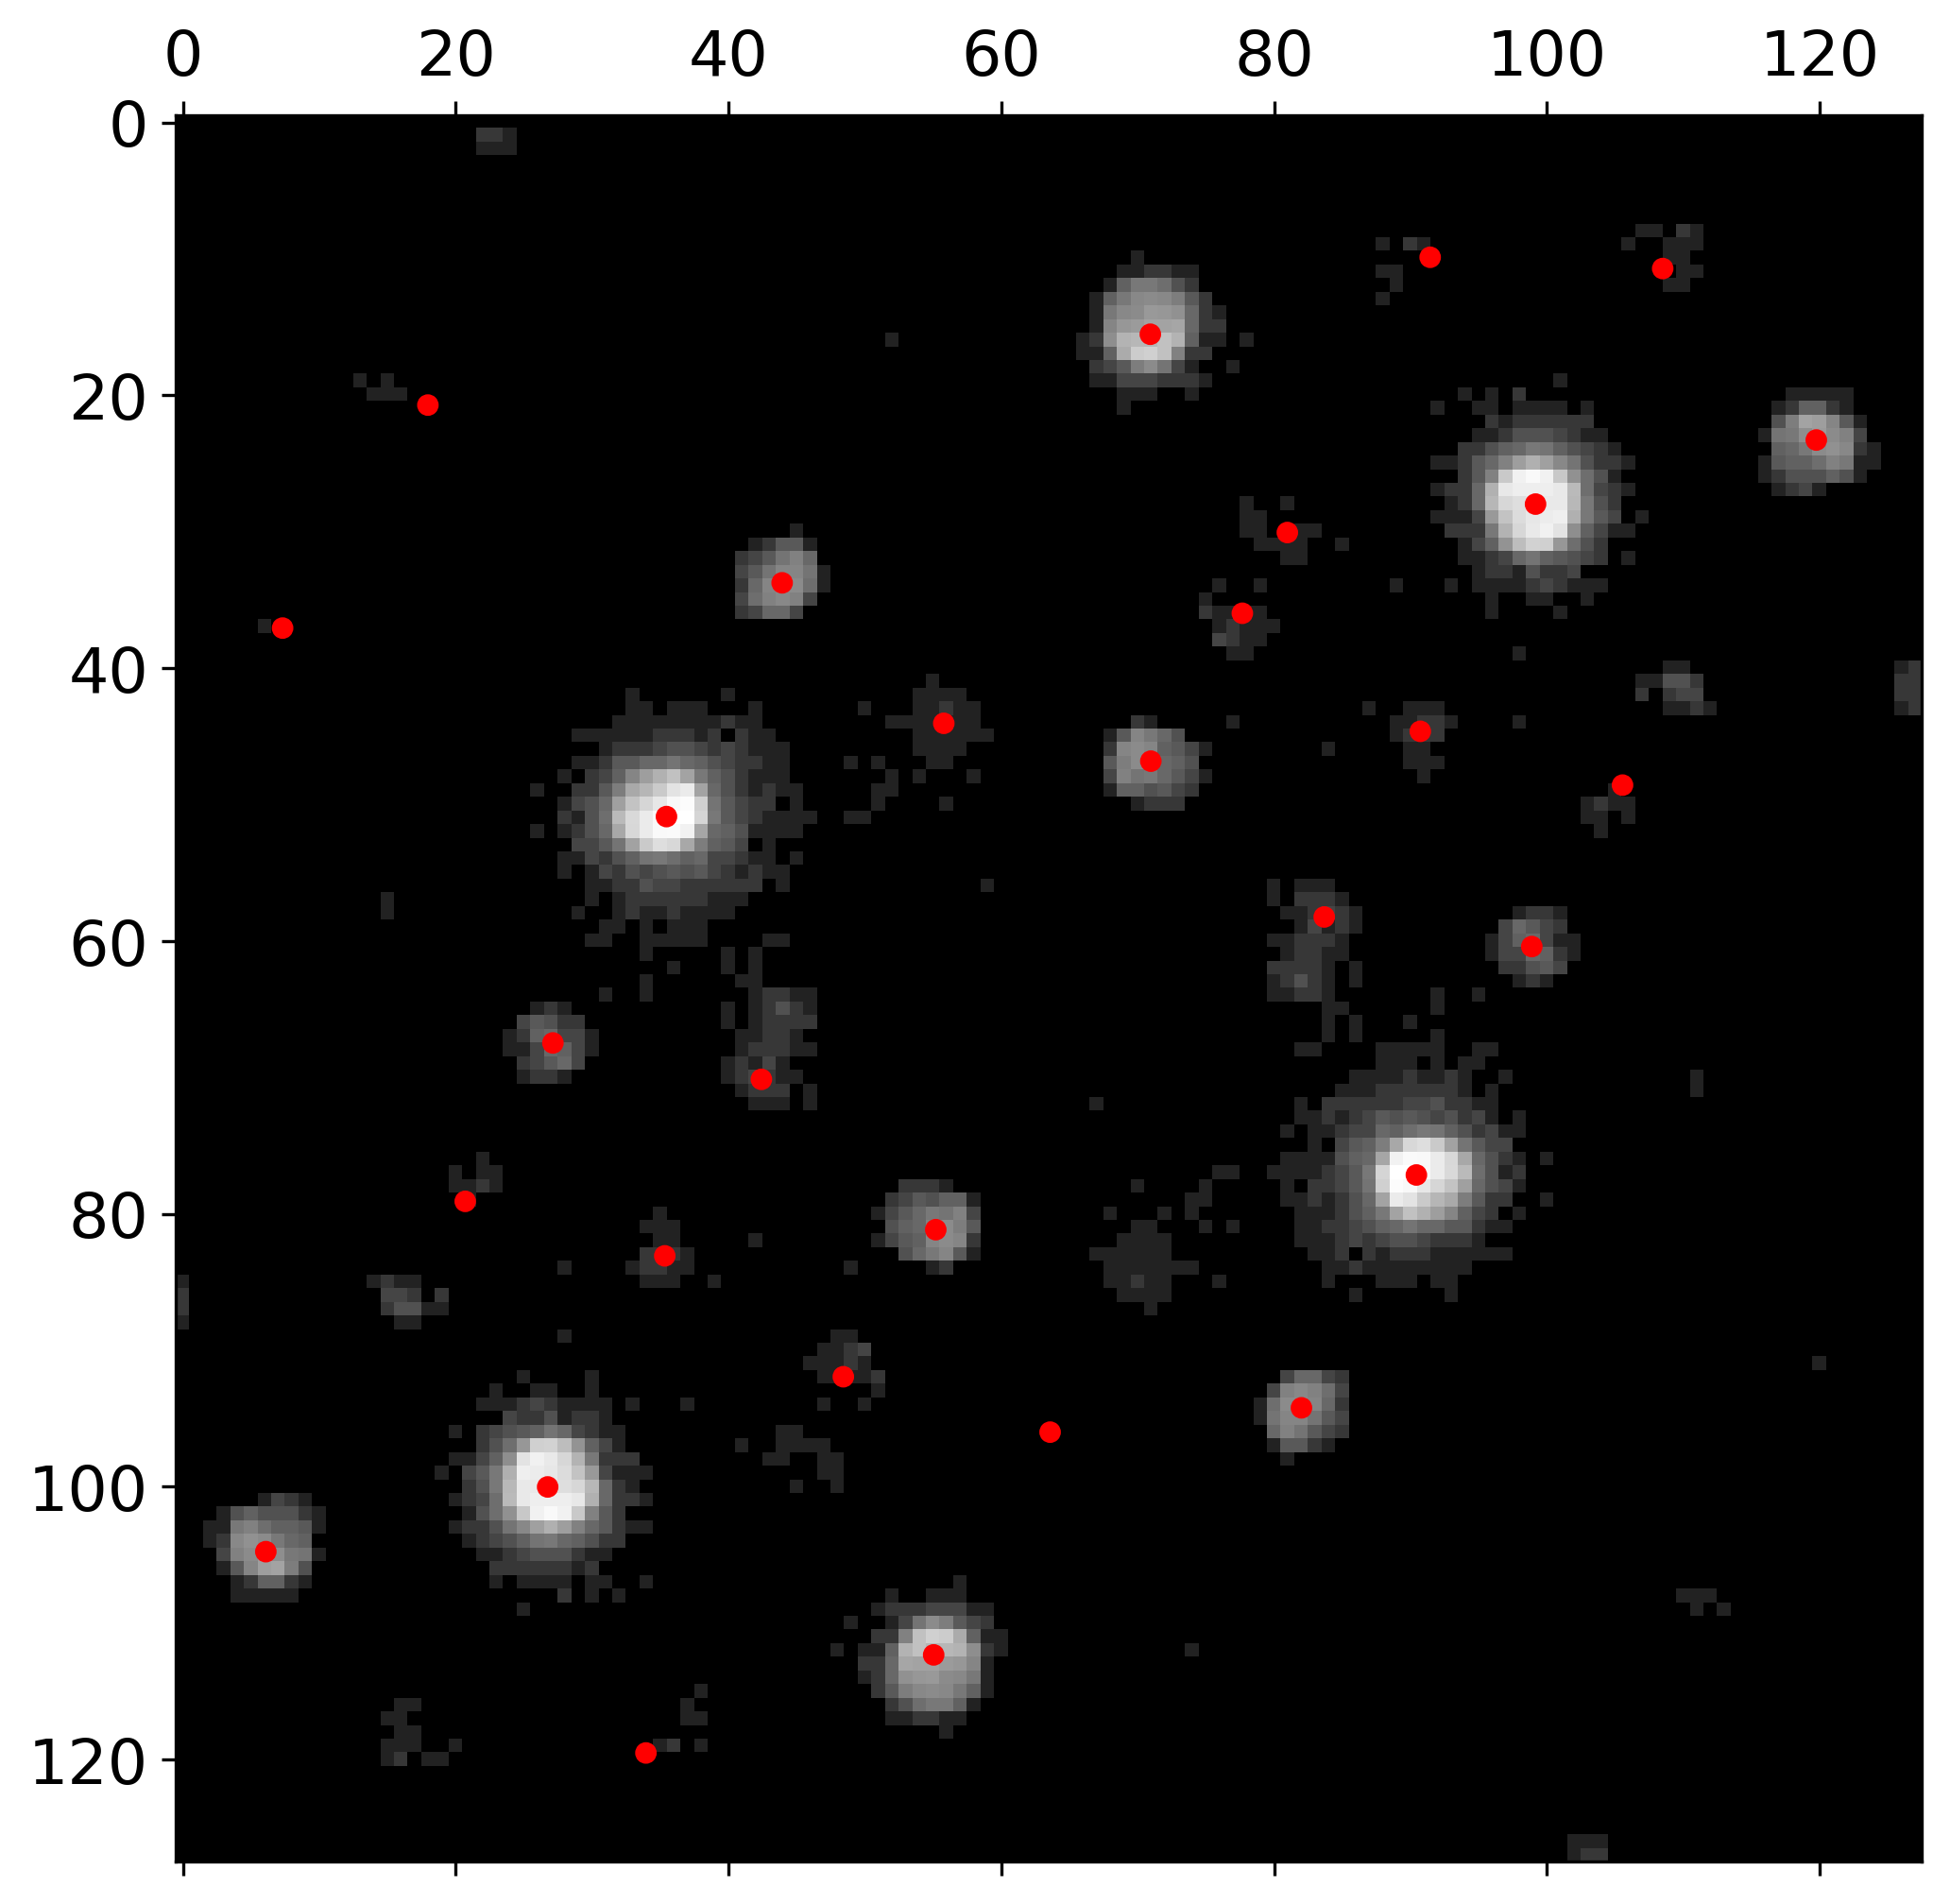

In [25]:
#display the bragg disk detection of pixel [50,60]
Rx, Ry = 50,60
corrPower=1
sigma=1
edgeBoundary=2
minRelativeIntensity=0.0001
relativeToPeak=0
minPeakSpacing=1
minAbsoluteIntensity = 0.3
maxNumPeaks=100
subpixel='poly'
upsample_factor=16
disks_selected=py4DSTEM.process.diskdetection.find_Bragg_disks_single_DP(datacube_symmetrize.data[Rx,Ry],probe_kernel,corrPower=corrPower,sigma=sigma,
                                                                       edgeBoundary=edgeBoundary,minRelativeIntensity=minRelativeIntensity,
                                                                       relativeToPeak=relativeToPeak,minPeakSpacing=minPeakSpacing,
                                                                       minAbsoluteIntensity=minAbsoluteIntensity,maxNumPeaks=maxNumPeaks,
                                                                       subpixel=subpixel,upsample_factor=upsample_factor)
#py4DSTEM.visualize.show_points(datacube_symmetrize.data[Rx][Ry], disks_selected.data['qx'], disks_selected.data['qy'],s=1,scale=20,alpha=1,pointcolor='r',scaling='log')
#py4DSTEM.visualize.show_points(datacube_info[Rx][Ry], disks_selected.data['qx'], disks_selected.data['qy'],s=1,scale=20,alpha=1,pointcolor='r',scaling='log')
py4DSTEM.visualize.show_points(datacube_symmetrize.data[Rx][Ry], braggpeaks_raw.pointlists[Rx][Ry].data['qx'], braggpeaks_raw.pointlists[Rx][Ry].data['qy'],s=1,scale=20,alpha=1,pointcolor='r',scaling='log')

# Obtain the Bragg vector map (BVM)

In [26]:
bvm_raw = get_bragg_vector_map_raw(braggpeaks_raw,datacube.Q_Nx,datacube.Q_Ny)

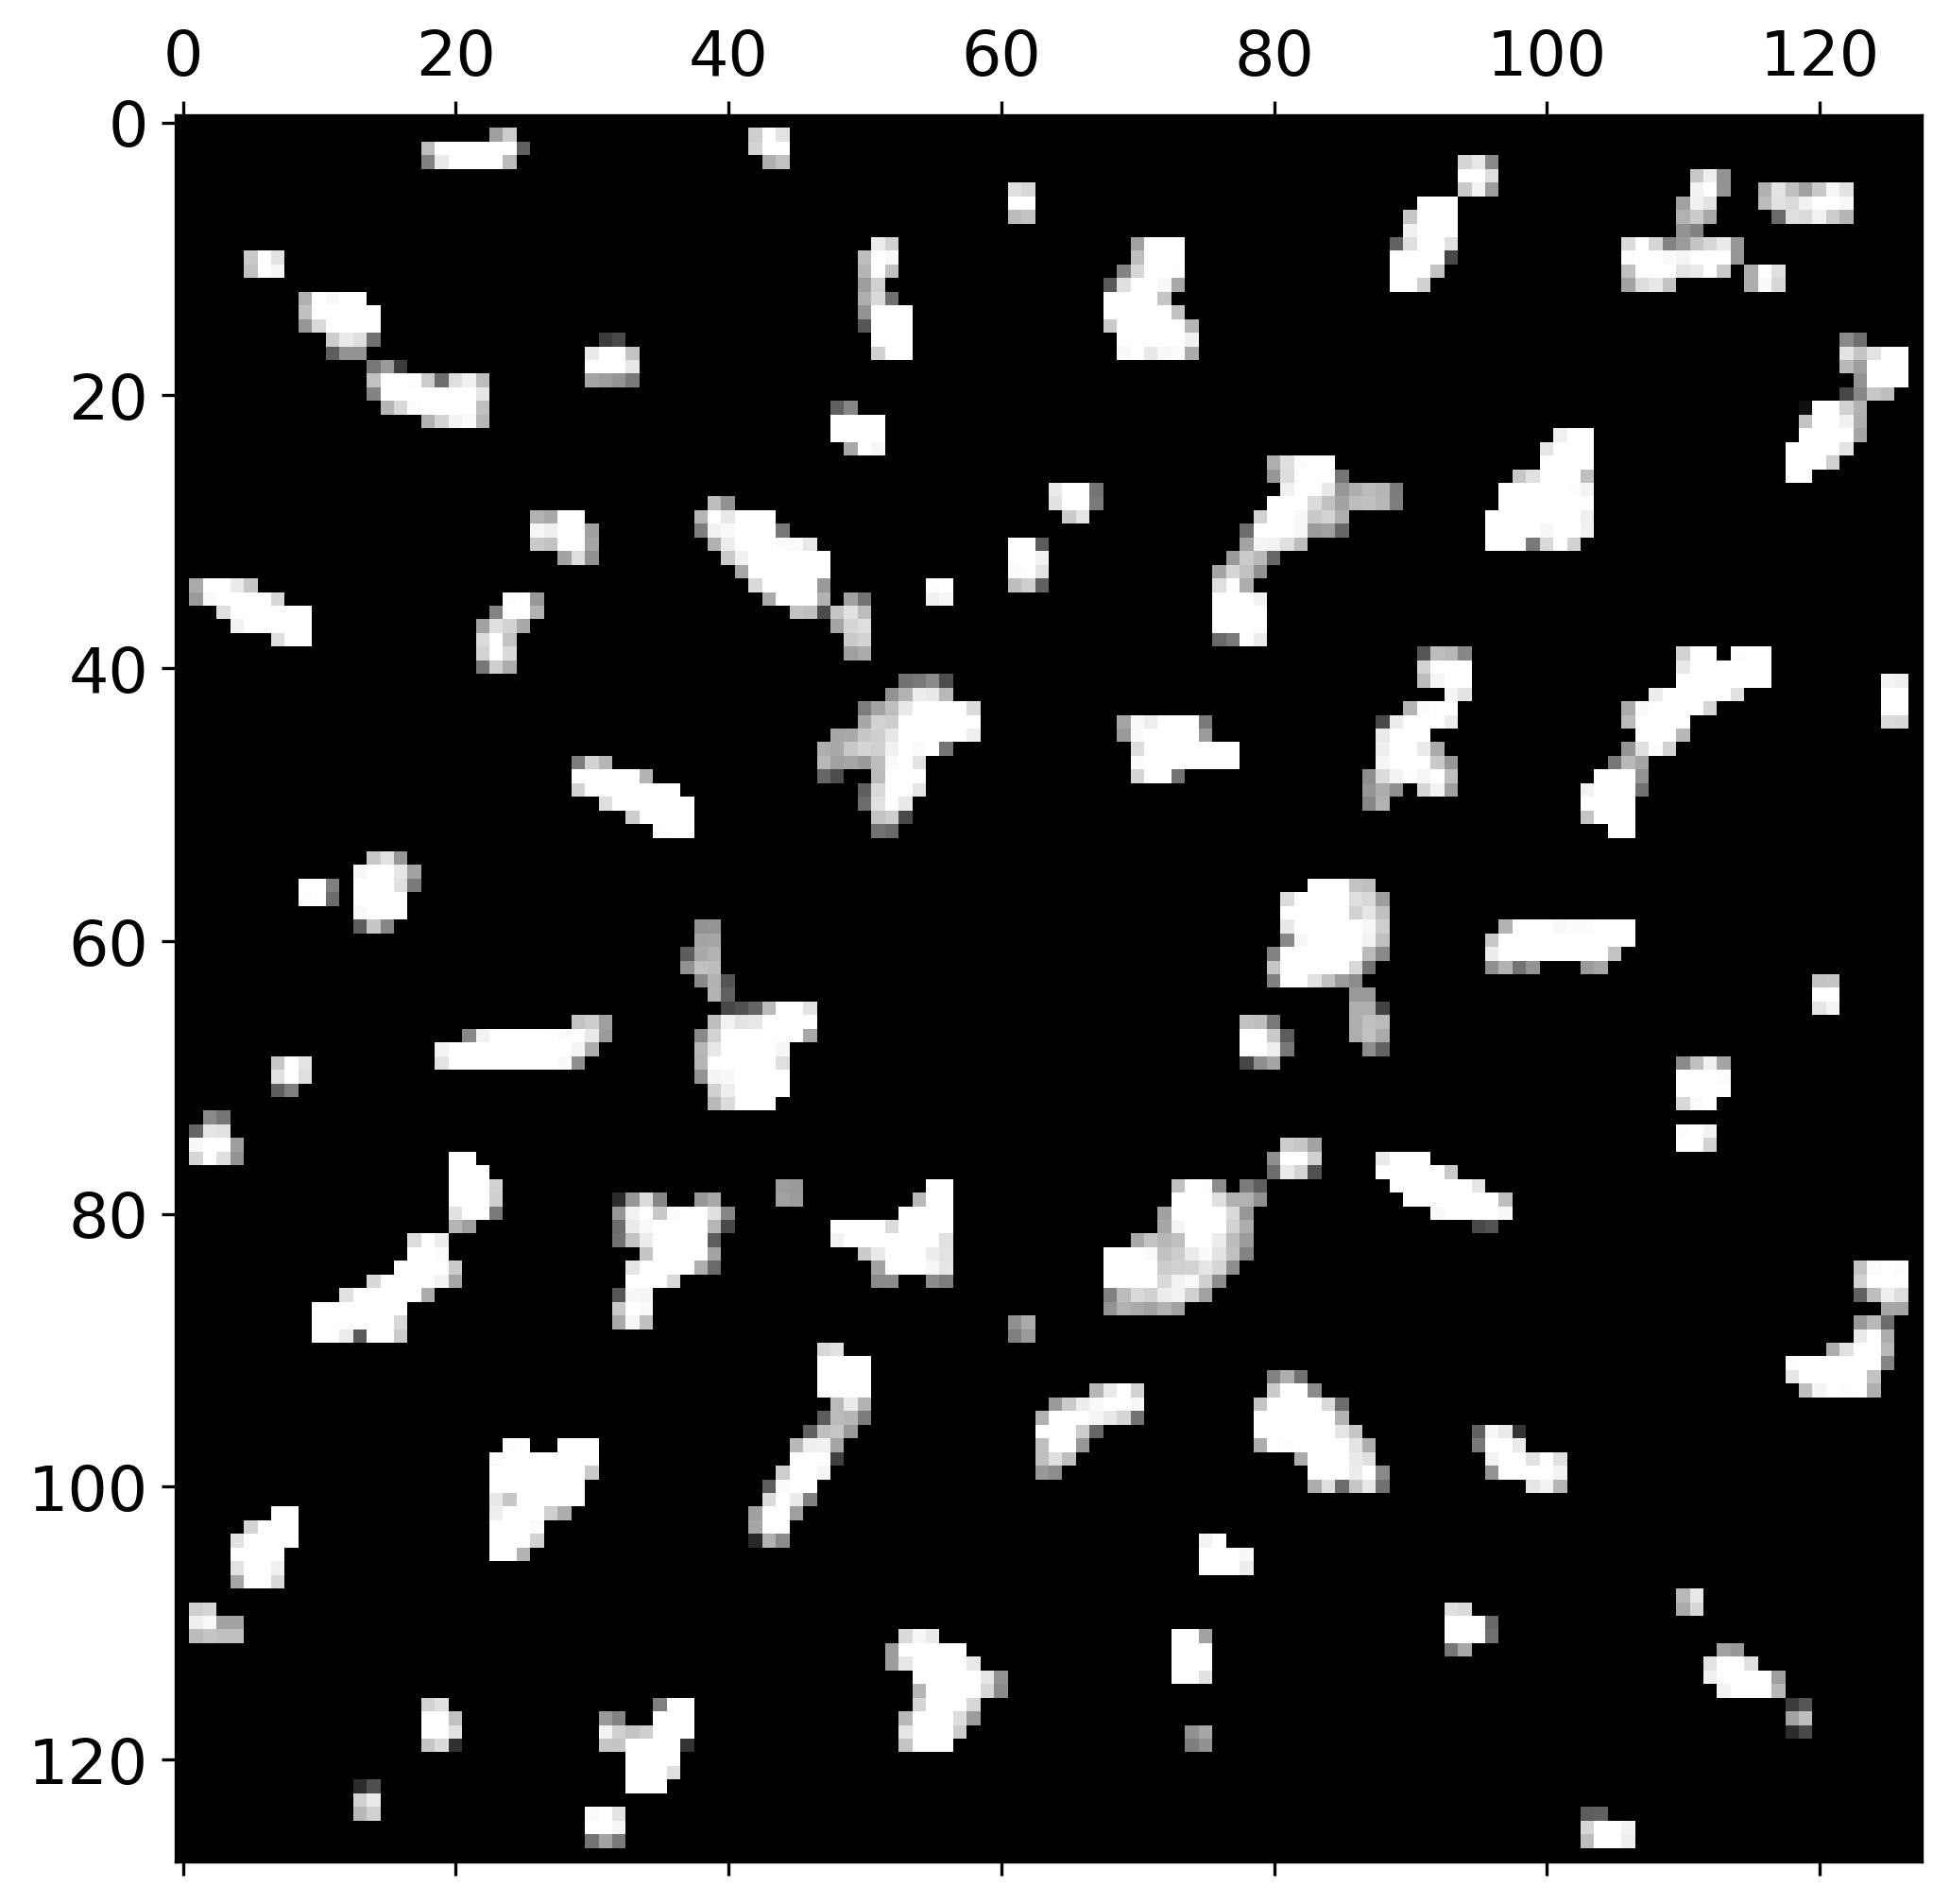

In [27]:
py4DSTEM.visualize.show(bvm_raw,cmap='gray',scaling='log',clipvals='manual',min=0,max=12)

In [28]:
#Obtain local maximum points from bragg vector map
gx,gy,gI = py4DSTEM.process.utils.get_maxima_2D(
                bvm_raw,
                edgeBoundary=1,
                minSpacing=0,
                minRelativeIntensity=0.001,
                relativeToPeak=0,
                maxNumPeaks=60,
                subpixel='none'
)

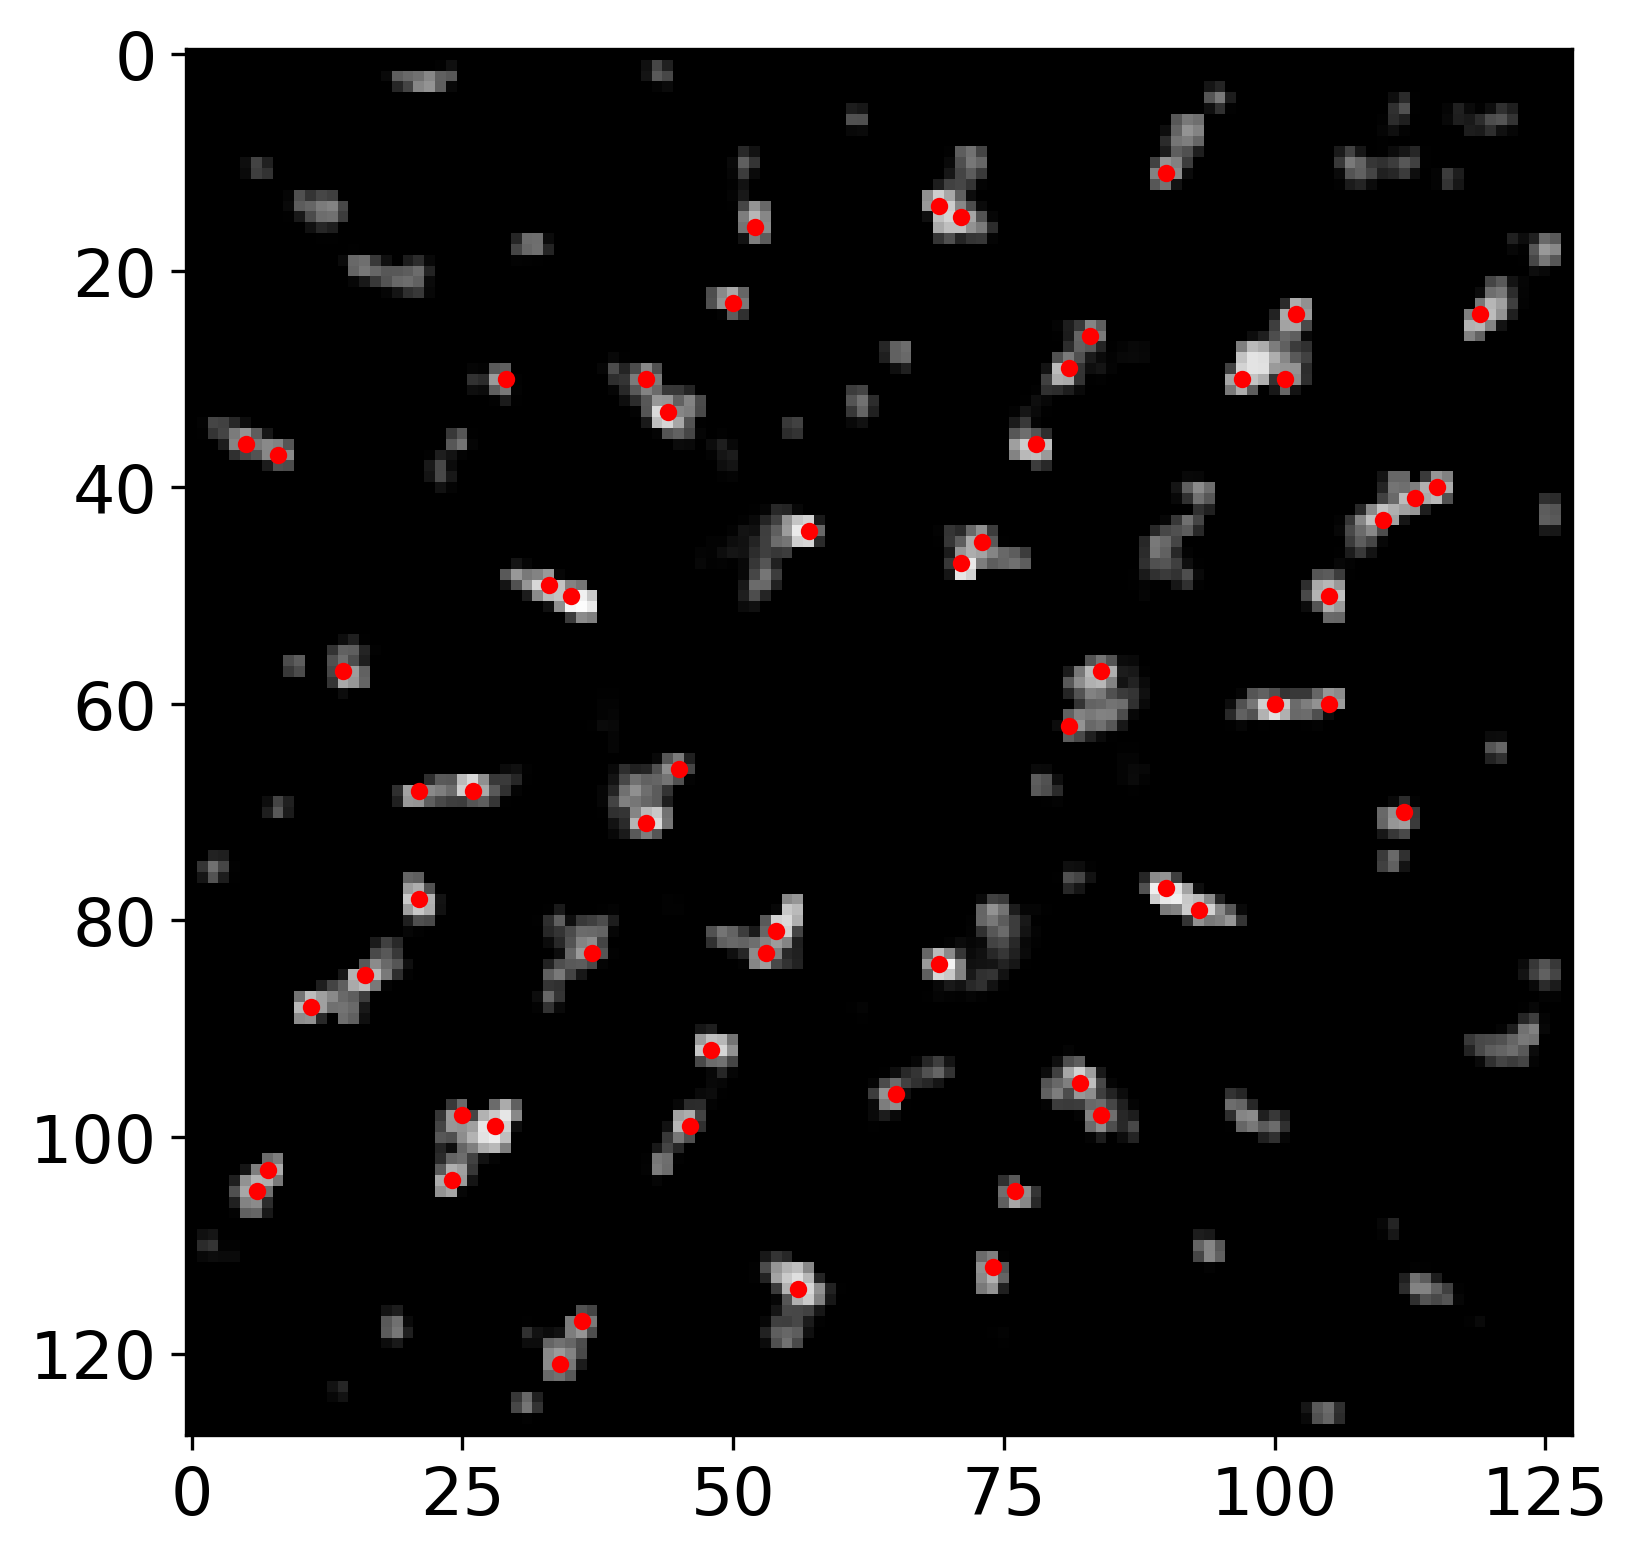

In [29]:
plt.imshow(np.log(bvm_raw+1), cmap='gray')
for i in range(len(gx)):
    Qx, Qy = int(gx[i]), int(gy[i])
    plt.scatter(Qy, Qx, c='r', s=10)

# Obtain bragg disk intensity/probability list of DPs

Total number of bragg disks is:60


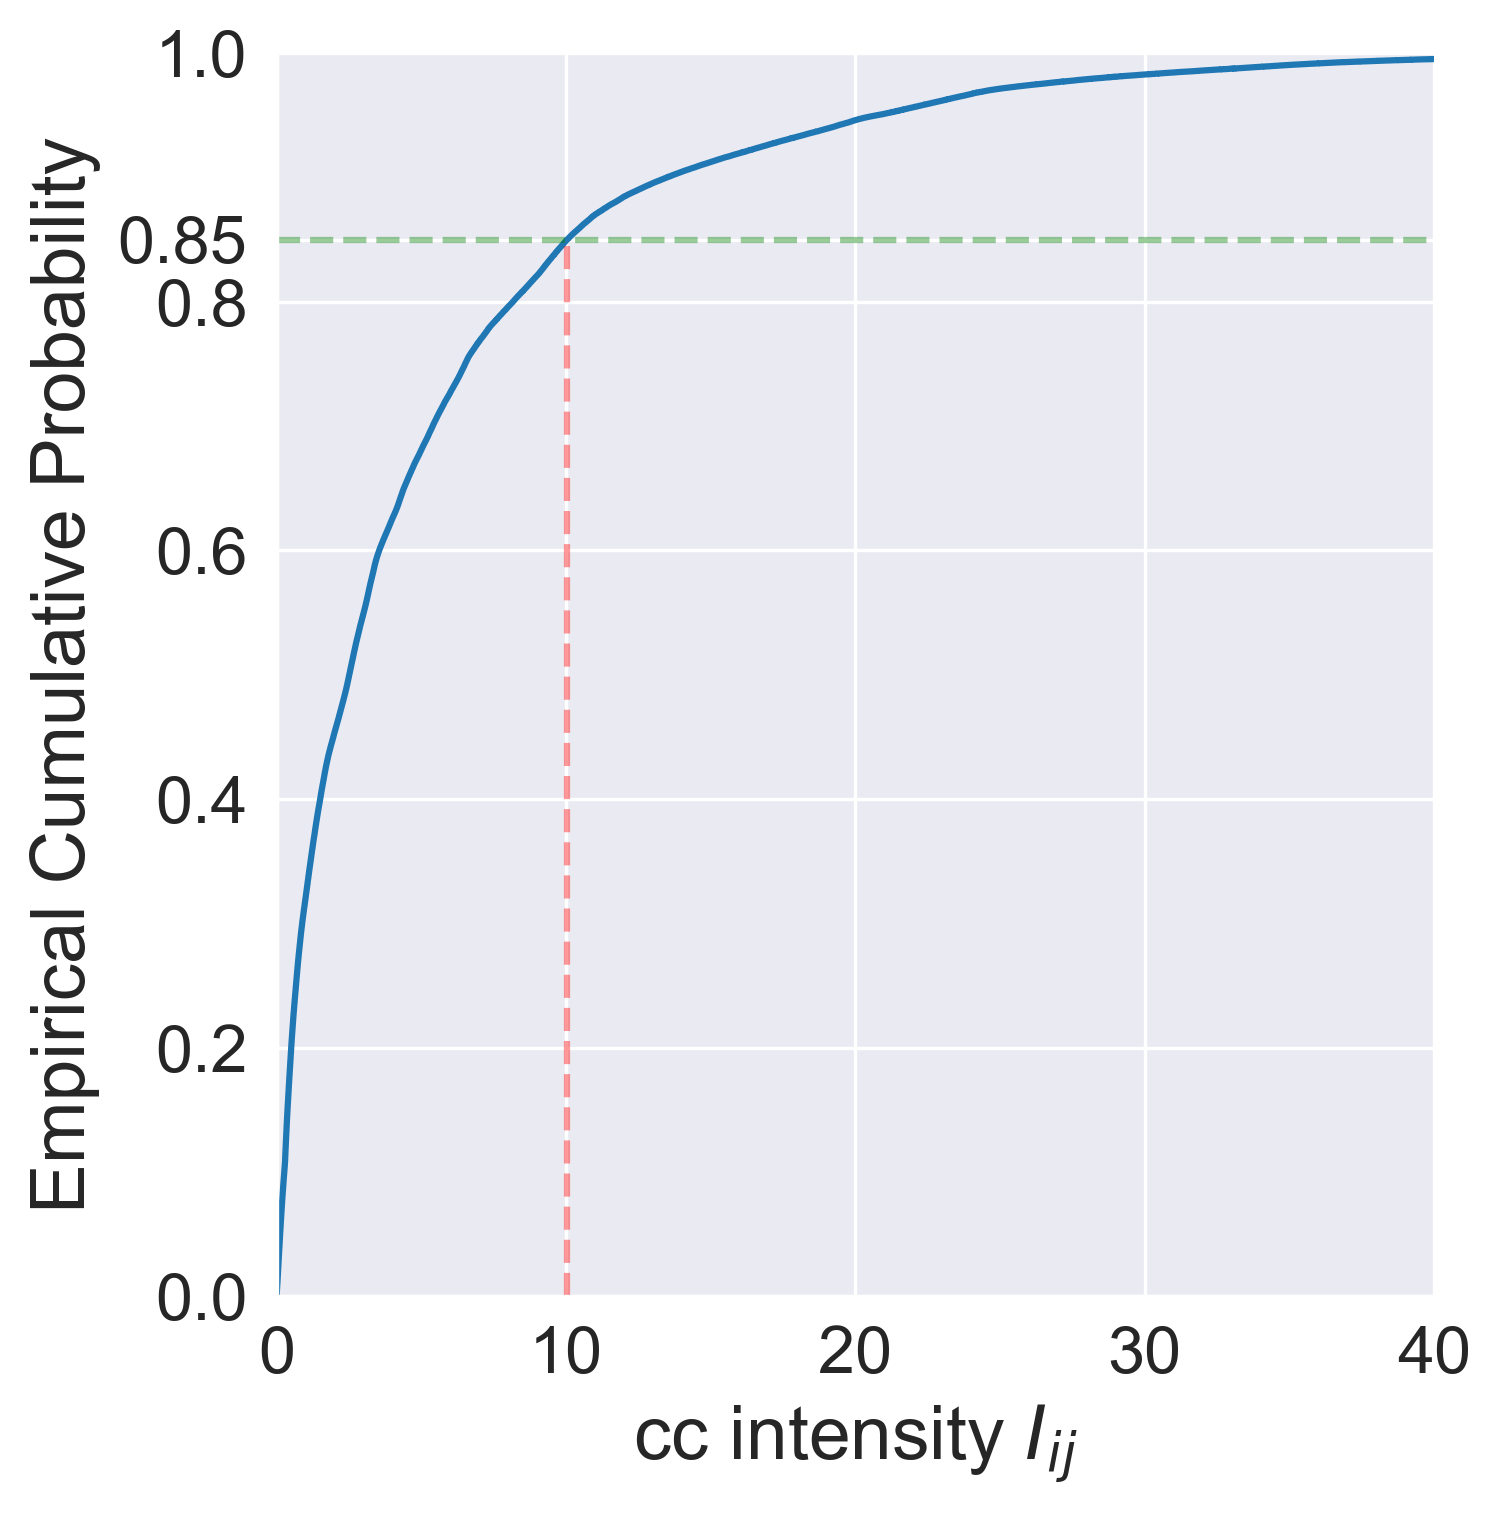

In [30]:
braggpeaks_intensity = create_intensity(braggpeaks_raw, datacube_symmetrize, gx, gy, probe_kernel_FT)
I_0 = find_I0(braggpeaks_intensity)
braggpeaks_intensity = np.minimum(braggpeaks_intensity, I_0)

In [31]:
braggpeaks_intensity = np.log(braggpeaks_intensity + 1)
braggpeaks_prob = np.zeros(braggpeaks_intensity.shape)
for i in range(braggpeaks_prob.shape[0]):
    for j in range(braggpeaks_prob.shape[1]):
        braggpeaks_prob[i][j] = braggpeaks_intensity[i][j] / max(braggpeaks_intensity[i][j])

In [32]:
#find beta
beta = find_beta(datacube_symmetrize, braggpeaks_prob, particle_labels)

In [33]:
print(I_0, beta)

10.04384832220843 0.005999589226595091


# GMM clustering

12


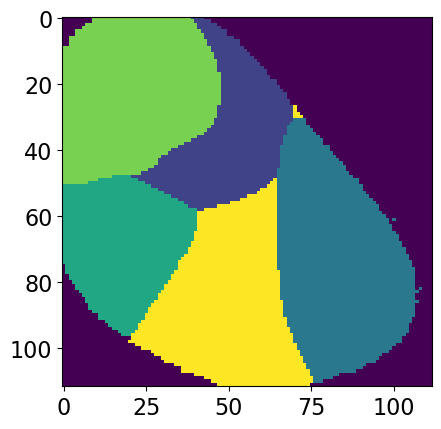

In [37]:
#GMM segmentation
X = braggpeaks_prob[particle_labels == 1]
real_pos = np.array(np.where(particle_labels == 1)).T # real space position (x,y)
alpha=beta
X = np.hstack((real_pos,alpha*X)) # Incorporate spatial proximity in this way.
n_components = 5
### "covariance_type" has a huge difference on the segmentation results. Try to play around and figure out how it affects the clustering results
gm = GaussianMixture(n_components=n_components, random_state=0, reg_covar=1e-6, warm_start=True, covariance_type = 'diag').fit(X)
label = np.zeros((particle_labels.shape))
label[np.where(particle_labels == 1)] = gm.predict(X)+1
#prob = gm.predict_proba(X)
print(gm.n_iter_)
plt.style.use('default')
fig = plt.figure(figsize=(6.4, 4.8))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 300
plt.imshow(label)

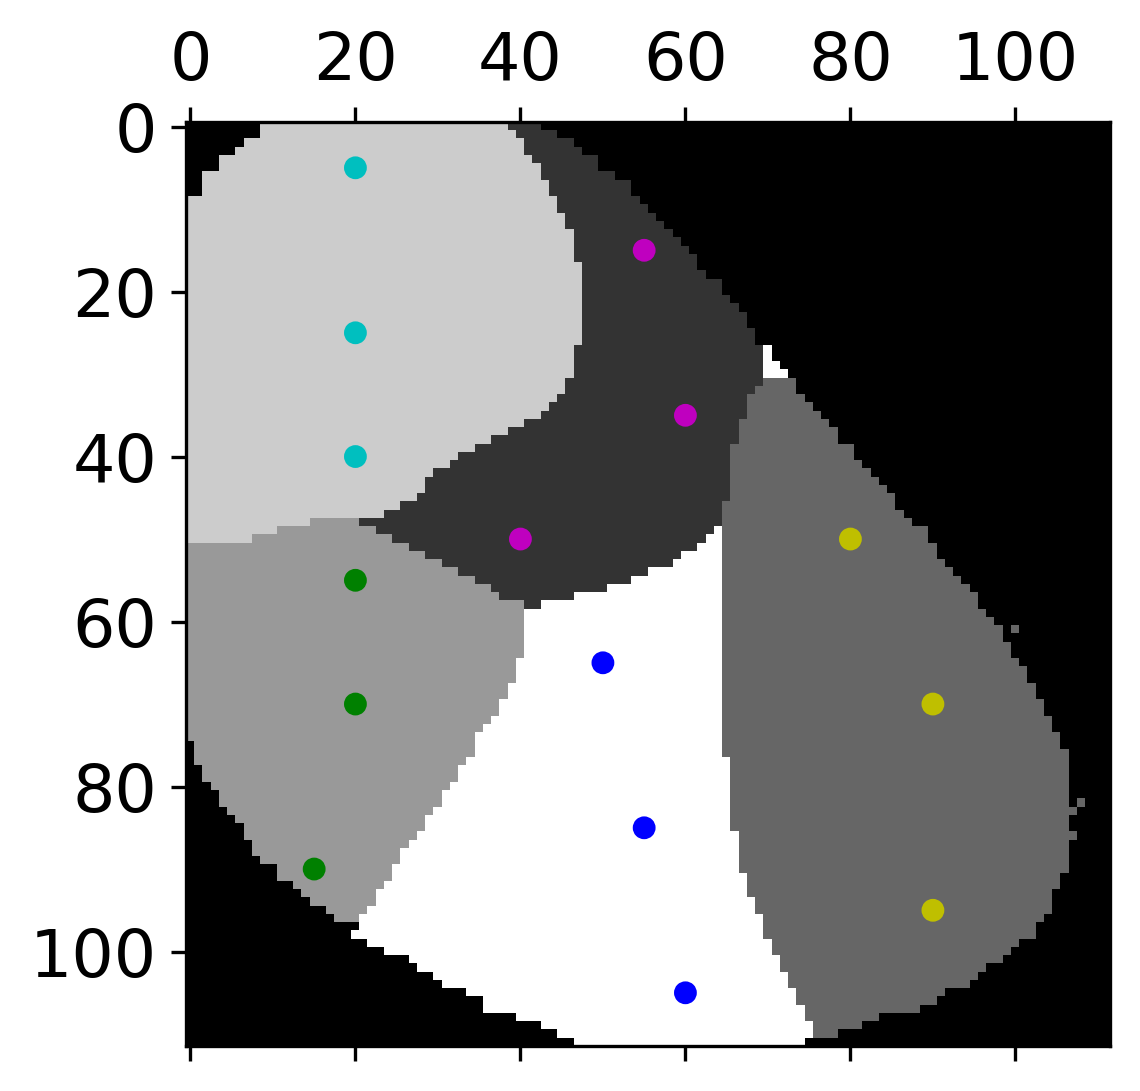

In [39]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.dpi': 300})
rxs = 15,35,50, 65,85,105, 5,25,40, 55,70,90, 50,70,95,    
rys = 55,60,40, 50,55,60, 20,20,20, 20,20,15, 80,90,90,    
colors=['m','m','m', 'b','b','b', 'c','c','c',
        'g','g','g', 'y','y','y']
py4DSTEM.visualize.show_points(label,x=rxs,y=rys,pointcolor=colors,figsize=(4,4),scale=20)

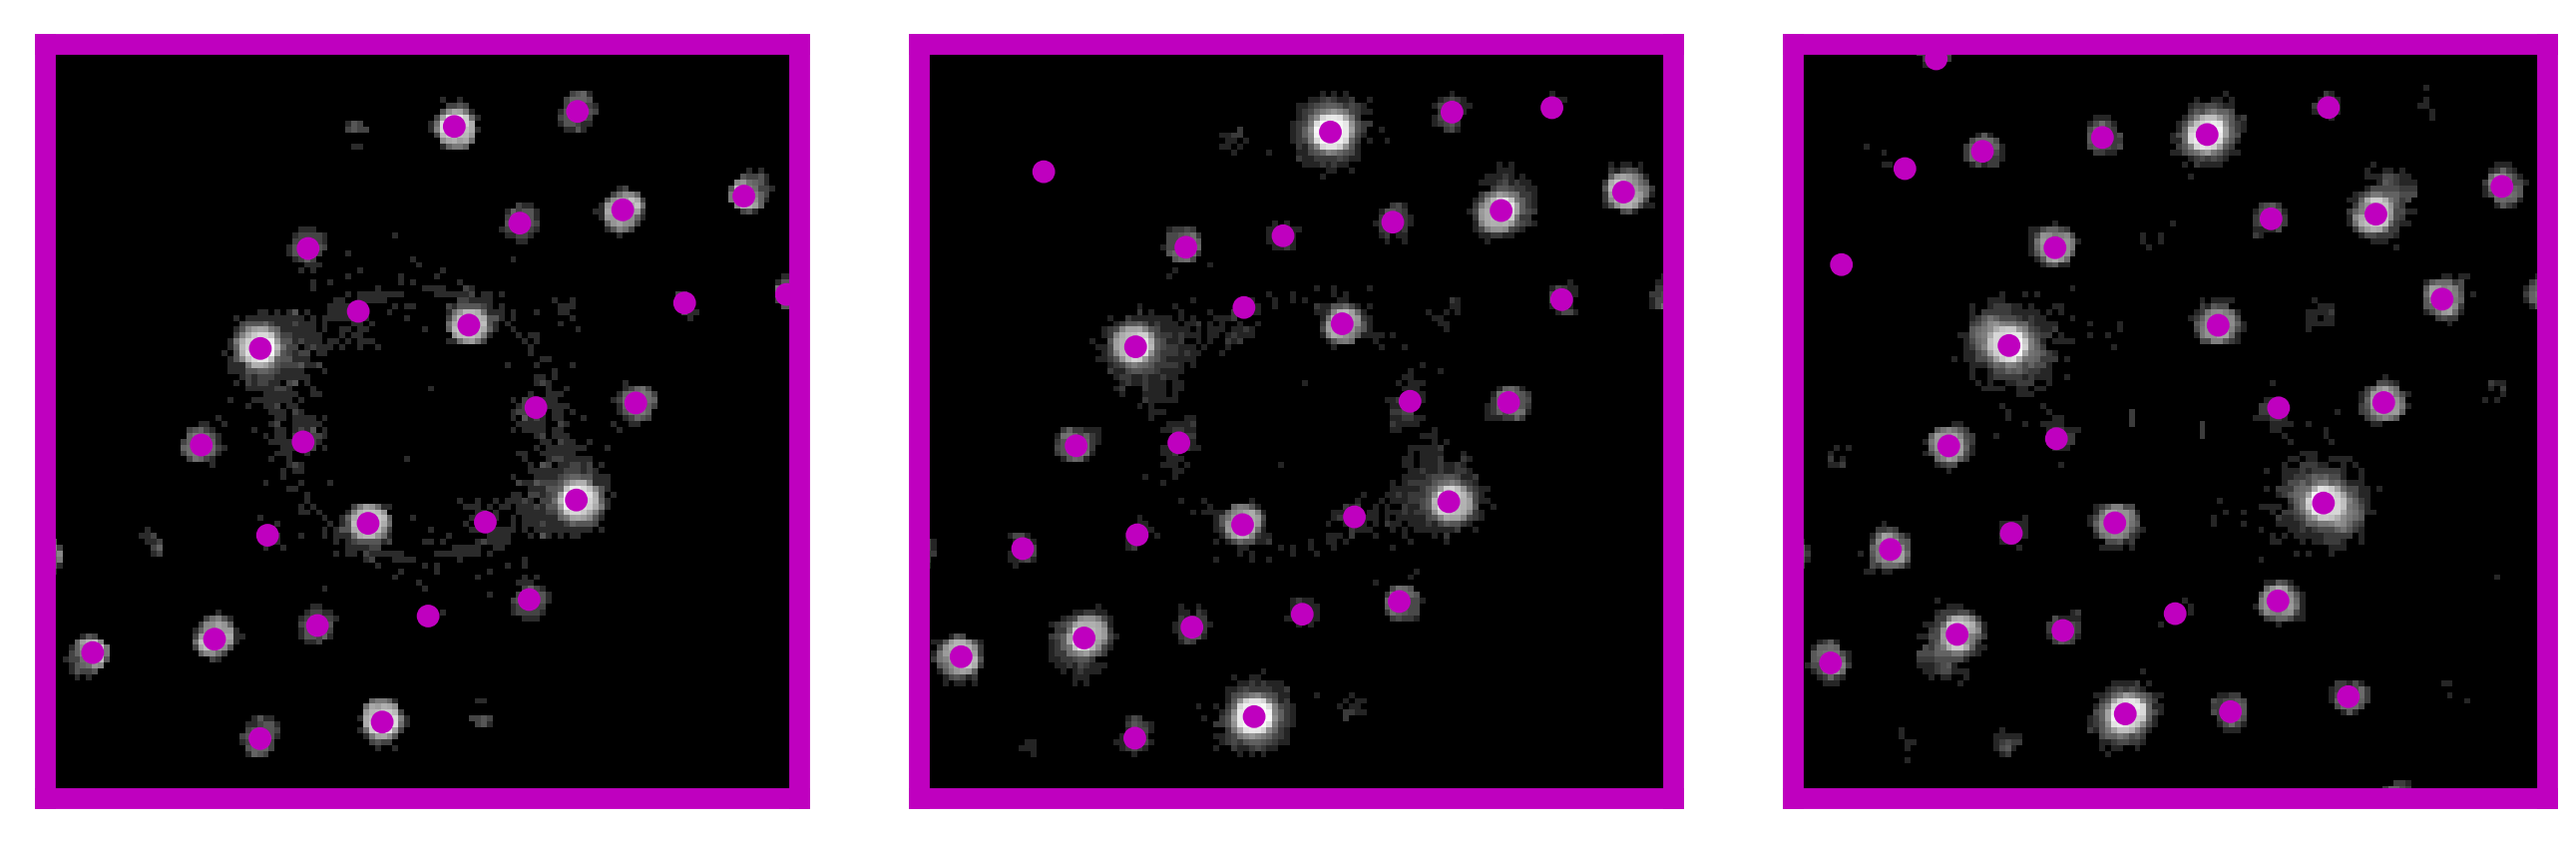

In [41]:
# cluster 1
k=0
dp1=datacube_symmetrize.data[rxs[0+k*3],rys[0+k*3],:,:]
dp2=datacube_symmetrize.data[rxs[1+k*3],rys[1+k*3],:,:]
dp3=datacube_symmetrize.data[rxs[2+k*3],rys[2+k*3],:,:]
py4DSTEM.visualize.show_image_grid(lambda i:[dp1,dp2,dp3][i],H=1,W=3,axsize=(3,3),
                                   scaling='log',
                                   scale = 20,
                                   get_bordercolor=lambda i:colors[i+k*3],
                                   get_x=lambda i:braggpeaks_raw.pointlists[rxs[i+k*3]][rys[i+k*3]].data['qx'],
                                   get_y=lambda i:braggpeaks_raw.pointlists[rxs[i+k*3]][rys[i+k*3]].data['qy'],
                                   get_pointcolors=lambda i:colors[i+k*3],
                                   )

# Probability plots

[85 49] [73 82]


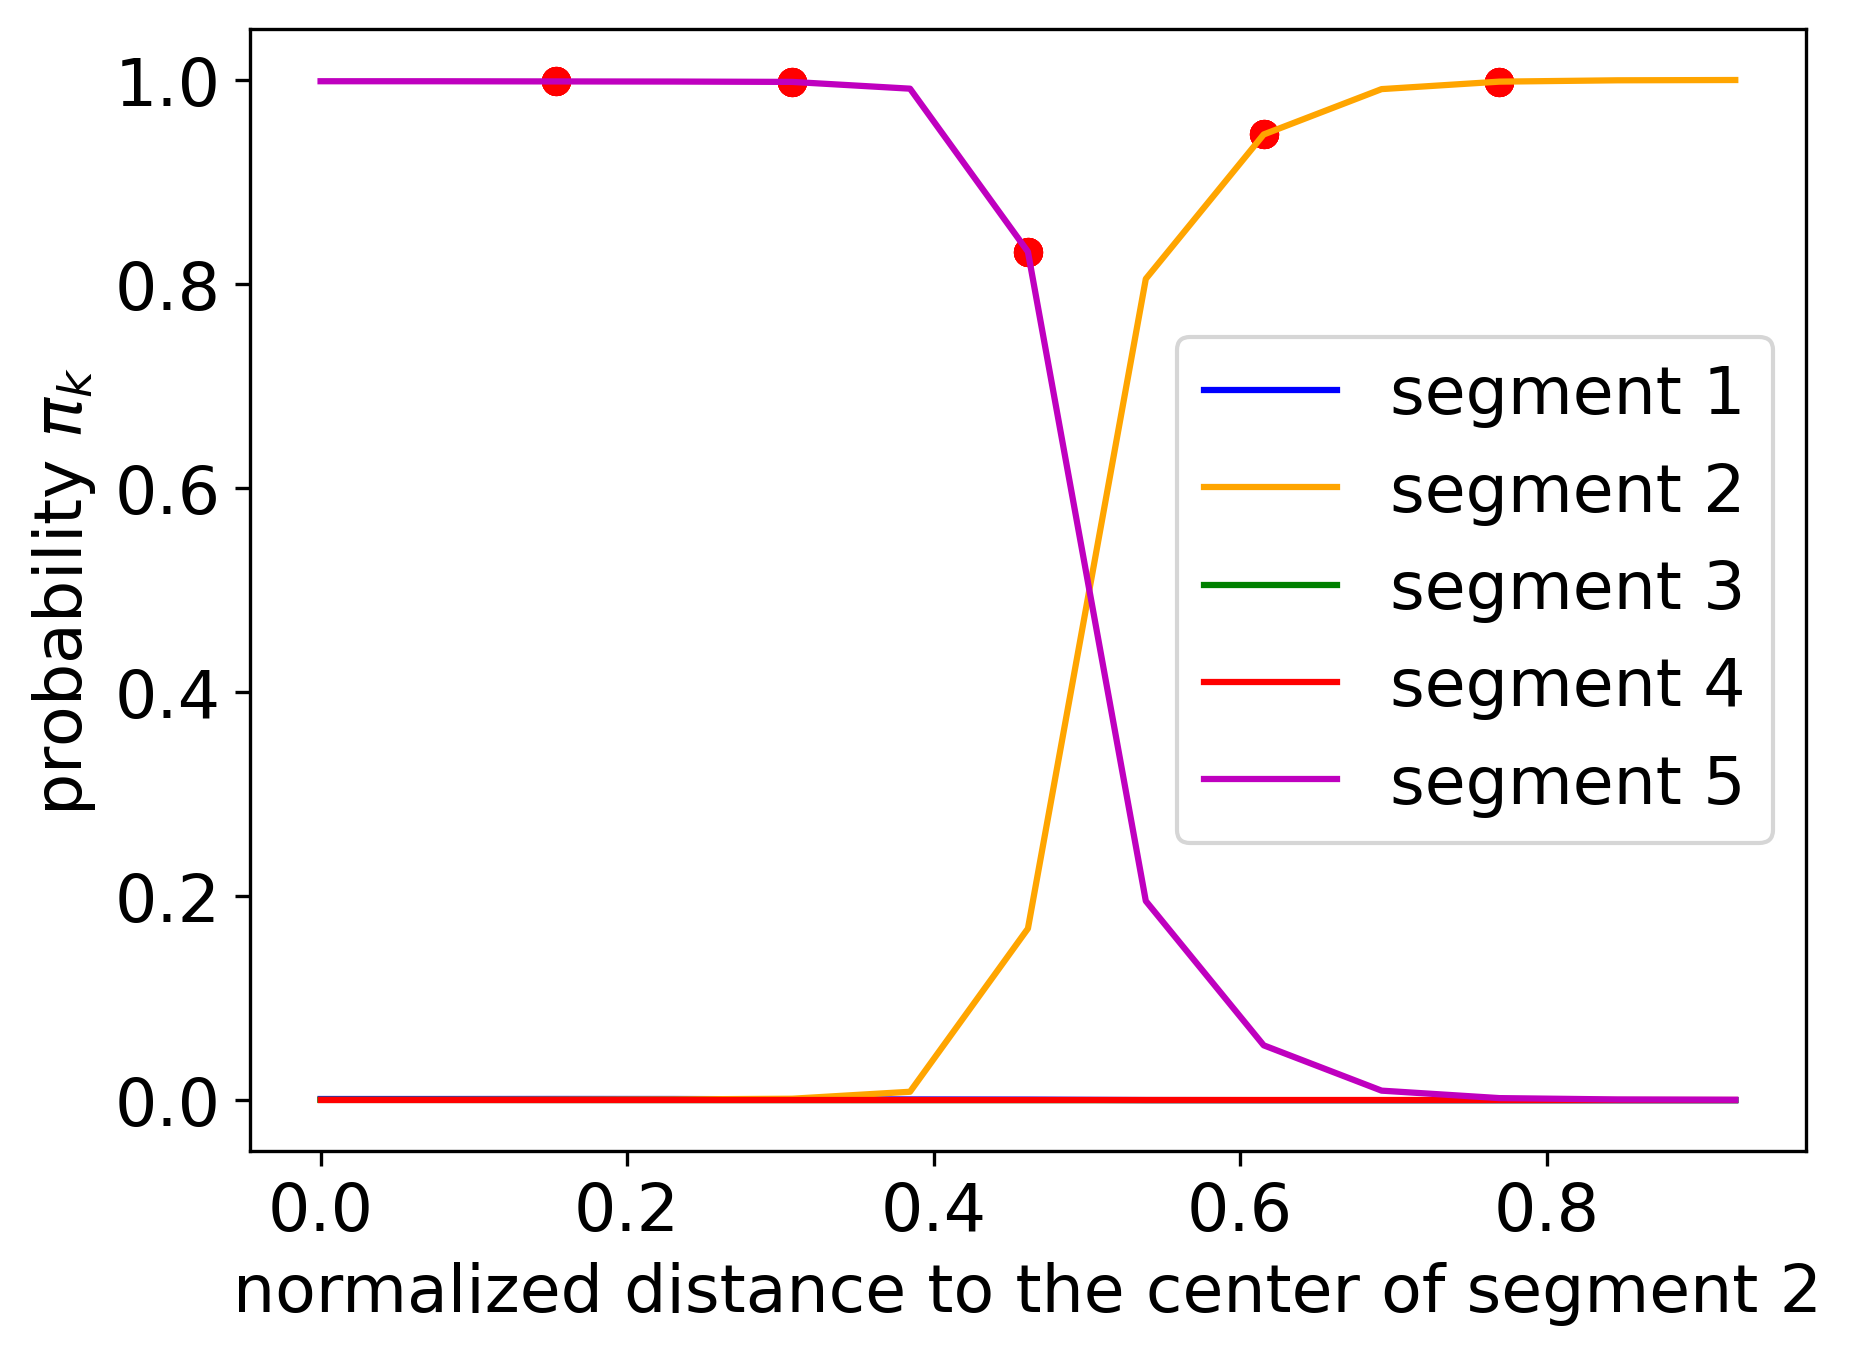

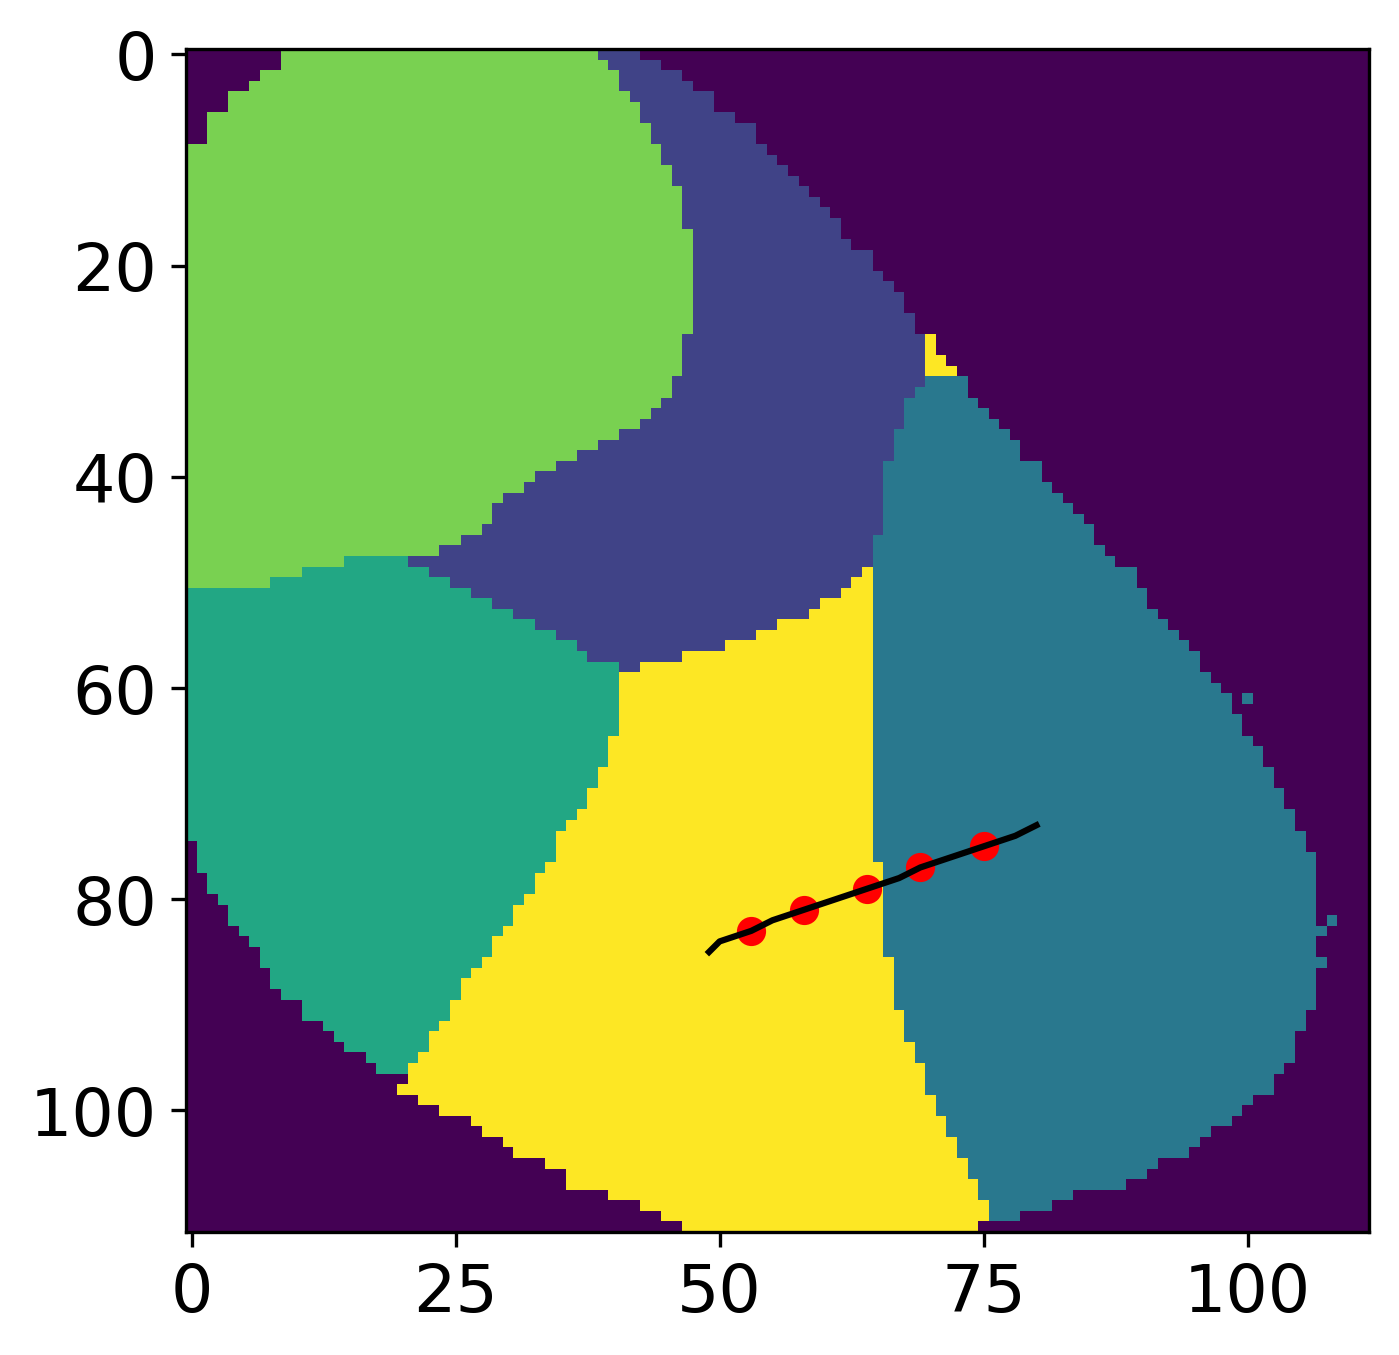

In [42]:
prob = gm.predict_proba(X)

cov_ls = []
for i in range(n_components):
    diff = X - gm.means_[i]
    cov = diff.T @ (prob[:, i][:, np.newaxis] * diff) / prob[:, i].sum()
    #a = np.diag(cov)
    #a1, a2 = np.mean(a[:2]), np.mean(a[2:])
    #temp = np.concatenate((np.repeat(a1, 2), np.repeat(a2, X.shape[1]-2)))
    cov_ls.append(cov)
    
cluster1=4
cluster2=1
X_plot, prob, middle_plot, middle_prob = plot_transit_prob(gm, cov_ls, braggpeaks_prob, alpha, 
                                        label, cluster1, cluster2, 100)